In [1]:
# import packages
import glob
from pathlib import Path
import scipy.stats
import os
import numpy as np
from datetime import datetime
from datetime import timedelta
import pandas as pd
import calendar
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import cartopy.crs as ccrs
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from pathos.threading import ThreadPool as Pool
from scipy.stats import gaussian_kde
import xarray as xr
from matplotlib import cm
from textwrap import wrap
import matplotlib
from collections import Counter

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
from f_sr_calculation import *

In [3]:
work_dir=Path("/mnt/u/LSM root zone/global_sr")
data_dir=Path("/mnt/u/LSM root zone/data_irrigation_paper")
fig_dir=Path("/mnt/u/LSM root zone/figs_irrigation_paper")

In [4]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [5]:
c1 = '#D81B60'
c2 = '#1E88E5'
c3 = '#FFC107'

In [6]:
colors =['white','white','white']
cmap_grey = LinearSegmentedColormap.from_list('cm',colors, N=3)
cmap_ylgnbu = cm.get_cmap('YlGnBu')

In [7]:
#Europe
lat_min_e, lat_max_e = 35,63
lon_min_e, lon_max_e = -12,18

#Asia
lat_min_a, lat_max_a = -11,26
lon_min_a, lon_max_a = 65,120

#us
lat_min_u, lat_max_u = 20,55
lon_min_u, lon_max_u = -130,-70

#south america
lat_min_s, lat_max_s = -33,-4
lon_min_s, lon_max_s = -58,-32

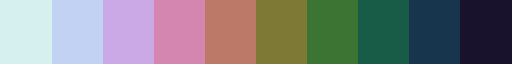

In [8]:
cmap = cm.get_cmap('cubehelix_r', 12)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
cmap_sr = ListedColormap(color_list[1:-1])
cmap_sr.set_over(color_list[-1])
cmap_sr.set_under(color_list[0])
cmap_sr.set_bad('lightgrey')
cmap_sr

## GRIDDED MAP IA AND IWU

In [9]:
iwu = xr.open_dataset(f'{data_dir}/irrigation_data/IWU_2011_2018_setyear.nc')

# from monthly mean values to mm/day and mm/year
dm = [31,28,31,30,31,30,31,31,30,31,30,31]
dm = dm*8

l=[]
for i in range(len(iwu.time)):
    p = iwu.IWUens[i,:,:]/dm[i]
    l.append(p)
iwu2 = xr.concat(l,dim='time')

iwu2m = iwu2.mean(dim='time')*365
iwu2m = iwu2m.transpose("lat", "lon")

In [10]:
ia = xr.open_dataset(f'{data_dir}/irrigation_data/AEI_HYDE_FINAL_IR_2005_fraction.nc')
ia = ia.AEI_HYDE_FINAL_IR_2005[0,:,:]

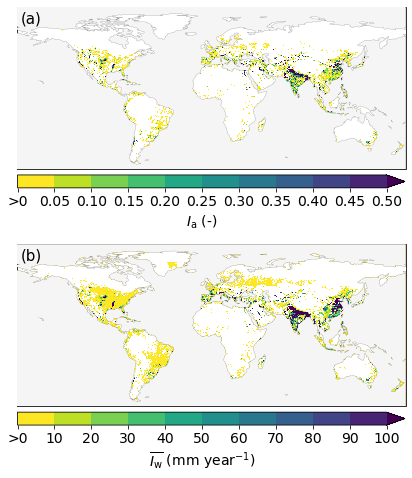

In [11]:
cmapv = plt.cm.viridis_r  # define the colormap
lvls = np.linspace(0,0.5,11) 
lvls2 = np.linspace(0,0.5,11) 

z = iwu2m.where(iwu2m==0)
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(211,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.001)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.12)
ax.set_global()
cf = ia.plot(ax=ax, cmap=cmapv, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
cf3 = z.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cbar = plt.colorbar(cf, orientation='horizontal',extend='max', pad=0.03, ticks=lvls2,shrink=0.434,aspect=30)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_xticklabels(['>0','0.05','0.10','0.15','0.20','0.25','0.30','0.35','0.40','0.45','0.50'])
cbar.set_label(label='$I_\mathrm{a}$ (-)', size=14)
ax.annotate('(a)',(-176,75),size=15,zorder=101)
ax.set_title(f'',size=12)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

lvls = np.linspace(0,100,11) 
lvls2 = np.linspace(0,100,11) 

z = ia.where(ia==0)
ax = fig.add_subplot(212,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.001)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.12)
ax.set_global()
cf = iwu2m.plot(ax=ax, cmap=cmapv, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
cf3 = z.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cbar = plt.colorbar(cf, orientation='horizontal',extend='max', pad=0.03, ticks=lvls2,shrink=0.434,aspect=30)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_xticklabels(['>0','10','20','30','40','50','60','70','80','90','100'])
cbar.set_label(label='$\overline{I_\mathrm{w}}$ ($\mathrm{mm}$ $\mathrm{year}^{-1}$)', size=14)
ax.annotate('(b)',(-176,75),size=15,zorder=101)
ax.set_title(f'',size=14)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

fig.savefig(f'{fig_dir}/irri_data.jpg',dpi=300,bbox_inches='tight')

## Method figure

In [12]:
catch_id = 'de_0000055'
sd_f0 = pd.read_csv(f'{data_dir}/{catch_id}_ni.csv',index_col=0)
sd_fiwu = pd.read_csv(f'{data_dir}/{catch_id}_iwu.csv',index_col=0)
sd_fopt = pd.read_csv(f'{data_dir}/{catch_id}_iaf.csv',index_col=0)
sd_f0.index = pd.to_datetime(sd_f0.index)
sd_fiwu.index = pd.to_datetime(sd_fiwu.index)
sd_fopt.index = pd.to_datetime(sd_fopt.index)

se_fiwu = pd.read_csv(f'{data_dir}/se_{catch_id}.csv',index_col=0)
se_fiwu.index = pd.to_datetime(se_fiwu.index)

/home/fvanoorschot/miniconda3/envs/sr_env/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/tmp/ipykernel_302/4010869893.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sd_fiwu4['se_cum2'] = se_cum2
/tmp/ipykernel_302/4010869893.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

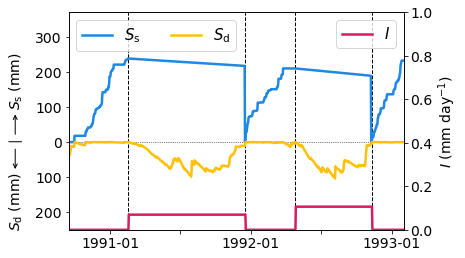

In [13]:
sd_fiwu2 = sd_fiwu.loc['1990-09-01':'1993-03-31']
sd_fiwu3 = sd_fiwu.loc['1990-09-01':'1993-03-31']
sd_fiwu2.index = pd.to_datetime(sd_fiwu2.index)
b1 = sd_fiwu.loc['2004-11-19':'2005-12-15'].se2.cumsum()
b2 = sd_fiwu.loc['2005-12-15':'2006-12-29'].se2.cumsum()
b3 = sd_fiwu.loc['2006-12-29':'2007-02-28'].se2.cumsum()
b4 = pd.concat([b1,b2,b3])

sd_fiwu.p_irri.loc['1990-09-10':'1990-09-30']= np.zeros(21)

# add irrigation Ss decline in Se-cum variable for the two irrigation periods
sd_fiwu4 = sd_fiwu3.loc['1991-02-16':'1991-12-17']
ini = sd_fiwu4.loc['1991-02-16'].se_cum
rate = sd_fiwu4.loc['1991-02-18'].p_irri
se_cum2=np.zeros(len(sd_fiwu4))
for i in range(len(sd_fiwu4)-1):
    se_cum2[i] = ini - i*rate
len(se_cum2)
sd_fiwu4['se_cum2'] = se_cum2
sd_fiwu3['se_cum2'] = sd_fiwu3['se_cum']
sd_fiwu3.loc['1991-02-16':'1991-12-17']['se_cum2'] = sd_fiwu4['se_cum2']

sd_fiwu5 = sd_fiwu3.loc['1992-04-25':'1992-11-10']
ini = sd_fiwu5.loc['1992-04-25'].se_cum
rate = sd_fiwu5.loc['1992-04-27'].p_irri
se_cum2=np.zeros(len(sd_fiwu5))
for i in range(len(sd_fiwu5)-2):
    se_cum2[i] = ini - i*rate
len(se_cum2)
sd_fiwu5['se_cum2'] = se_cum2
sd_fiwu3.loc['1992-04-26':'1992-11-10']['se_cum2'] = sd_fiwu5['se_cum2']

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
ax.hlines(0,pd.to_datetime('1990-09-15'),pd.to_datetime('1993-02-01'),color='k',linestyle=':',linewidth=0.7)
ax.vlines(pd.to_datetime('1992-04-26'),-400,400,color='k',linestyle='--',linewidth=1)
ax.vlines(pd.to_datetime('1992-11-10'),-400,400,color='k',linestyle='--',linewidth=1)
ax.vlines(pd.to_datetime('1991-02-16'),-400,400,color='k',linestyle='--',linewidth=1)
ax.vlines(pd.to_datetime('1991-12-17'),-400,400,color='k',linestyle='--',linewidth=1)
# ax.plot(sd_fiwu.index,sd_fiwu.se2, label='$S_{\mathrm{s}$')
# ax.plot(b1.index, b1, color='tab:blue',linewidth=2.5, label='$S_{\mathrm{s}}$')
# ax.plot(b2.index, b2, color='tab:blue',linewidth=2.5)
# ax.plot(b3.index, b3, color='tab:blue',linewidth=2.5)
# ax.plot(b4.index, b4, color=c1, linewidth=2.5, label='$S_{\mathrm{s}}$')
ax.plot(sd_fiwu3.index,sd_fiwu3['se_cum2'], color=c2, linewidth=2.5, label='$S_{\mathrm{s}}$')
ax.plot(sd_fiwu.index,sd_fiwu.Sd, color=c3, linewidth=2.5,label='$S_{\mathrm{d}}$')
ax2.plot(sd_fiwu2.index,sd_fiwu2.p_irri, color=c1, linewidth=2.5,label='$I$')

ax.set_yticks([-200,-100,0,100,200,300])
ax.set_yticklabels([200,100,0,100,200,300])
ax.set_ylim(-250,370)
ax2.set_ylim(0,1)
ax.set_xlim(pd.to_datetime('1990-09-15'),pd.to_datetime('1993-02-01'))
ax.set_xticks(['1991-01-01','1991-07-01','1992-01-01','1992-07-01','1993-01-01'])
ax.set_xticklabels(['1991-01','','1992-01','','1993-01'])

ax.text('1990-04-08',105,'$S_\mathrm{s}$ (mm)',size=14,rotation=90)
ax.text('1990-04-08',-240,'$S_\mathrm{d}$ (mm)',size=14,rotation=90)
ax.annotate('', xy=(-0.16,0.54), xycoords='axes fraction', xytext=(-0.16,0.43),arrowprops=dict(arrowstyle="->", color='k'))
ax.annotate('', xy=(-0.16,0.38), xycoords='axes fraction', xytext=(-0.16,0.27),arrowprops=dict(arrowstyle="<-", color='k'))
ax.annotate('', xy=(-0.185,0.405), xycoords='axes fraction', xytext=(-0.135,0.405),arrowprops=dict(arrowstyle="-", color='k'))
ax2.set_ylabel('$I$ ($\mathrm{mm}$ $\mathrm{day}^{-1}$)', size=14)
ax.tick_params(axis='both', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax.legend(ncol=2, fontsize=15,loc='upper left')
ax2.legend(ncol=1, fontsize=15,loc='upper right')
fig.savefig(f'{fig_dir}/sd_ss_timeseries_zoom.jpg',dpi=200,bbox_inches='tight')

## optimization of beta

In [14]:
df = pd.read_csv(f'{data_dir}/irrigation_data/combined_ia.csv',index_col=0) 
d = pd.read_csv(f'{data_dir}/f_optimization.csv',index_col=0)

In [15]:
# MINIMIZE ABSOLUTE ERROR
f_min=0
f_max=4
nmax=10000
b = np.linspace(0,2.5,1000)
A=np.zeros((len(b),12))

for n in range(1,len(b)+1):
    f = b[n-1]
    o = f*d['ia']
    er = o-d['fiwu']
    er2 = (o-d['fiwu'])**2
    er_m = er.mean()
    er_mse = np.mean(er**2)
    er_mae = np.mean(np.abs(er))
    er_std =er.std()
    er_med = er.median()
    er_iqr =er.quantile(0.75) - er.quantile(0.25)
    er_rmse = np.sqrt(np.mean((o-d['fiwu'])**2))
    er_q25 = er2.quantile(0.25)
    er_q75 = er2.quantile(0.75)
    er_q50 = er2.quantile(0.50)
    er_m = er2.mean()
    
    A[n-1,:] = [f,er_m,er_mse,er_mae,er_std,er_med,er_iqr,er_rmse,er_q25,er_q75,er_q50,er_m]

ind=find_nearest(A[:,1],0)
fopt_mean=np.round(A[ind,0],3)
    
ind=np.argmin(A[:,2],0)
fopt_mse=np.round(A[ind,0],3)

ind=np.argmin(A[:,3],0)
fopt_mae=np.round(A[ind,0],3)

ind=np.argmin(A[:,4])
fopt_std=np.round(A[ind,0],3)

ind=find_nearest(A[:,5],0)
fopt_median=np.round(A[ind,0],3)

ind=np.argmin(A[:,6])
fopt_iqr=np.round(A[ind,0],3)

ind=np.argmin(A[:,7])
fopt_rmse=np.round(A[ind,0],3)

/tmp/ipykernel_302/1798130560.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0.0,0.5,1.0,1.5,2.0,2.5],size=12)


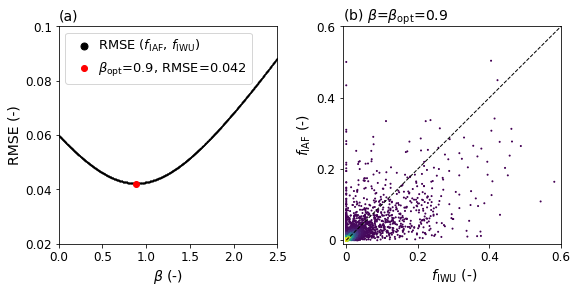

In [16]:
# RMSE figure optimization
fig = plt.figure(figsize=(9,4))
ax = fig.add_subplot(121)
plt.subplots_adjust(wspace=0.3)
ax.plot(A[:,0], A[:,7],'o',color='k',markersize=0.5)
ax.plot(1,1,'o',color='k',markersize=7,label=r'RMSE ($f_{\mathrm{IAF}}$, $f_{\mathrm{IWU}}$)')
ax.plot(fopt_rmse,0.042,'o',color='r',markersize=6,label=r'$\beta_{\mathrm{opt}}$='+str(np.round(fopt_rmse,1))+', RMSE=0.042')
ax.set_xlim(0,2.5)
ax.set_ylim(0.02,0.10)
ax.set_yticks([0.02,0.04,0.06,0.08,0.10])
ax.set_yticklabels([0.02,0.04,0.06,0.08,0.10],size=12)
ax.set_xticklabels([0.0,0.5,1.0,1.5,2.0,2.5],size=12)
ax.set_xlabel(r'$\beta$ (-)',fontsize=14)
ax.set_ylabel('RMSE (-)',fontsize=14)
ax.legend(fontsize=13,loc='upper left',handletextpad=0.1)
ax.set_title('(a)',size=14,loc='left')


d = d.dropna()
x = d['fiwu']
y = 0.9*d['ia']

# calculate point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

ax = fig.add_subplot(122)
# ax.scatter(x,y,c='tab:blue',s=2)
ax.scatter(x,y,c=z,s=1)
ax.plot([0,12],[0,12],'k--',linewidth=1)
ax.set_xlabel(' $f_{\mathrm{IWU}}$ (-)',fontsize=14)
ax.set_ylabel(r'$f_{\mathrm{IAF}}$ (-)',fontsize=14)
ax.set_xlim(-0.01,0.6)
ax.set_ylim(-0.01,0.6)
ax.set_yticks([0,0.2,0.4,0.6])
ax.set_xticks([0,0.2,0.4,0.6])
ax.set_yticklabels([0,0.2,0.4,0.6],size=12)
ax.set_xticklabels([0,0.2,0.4,0.6],size=12)
ax.set_title(r'(b) $\beta$=$\beta_{\mathrm{opt}}$=0.9',size=14,loc='left')
fig.savefig(f'{fig_dir}/monte_carlo_rmse.jpg',dpi=600,bbox_inches='tight')


## Sd TIMESERIES

In [17]:
ca0='br_0002356'
ca1='ca_0000689'
ca2='es_0000742'
ca3='in_0000252'

In [18]:
c2= '#00A4CCFF'
c3 = '#F95700FF'

/tmp/ipykernel_302/1891825032.py:61: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  iwu_mean = np.int(iwu.mean().values[0]*365) # annual mean IWU
/tmp/ipykernel_302/1891825032.py:98: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.


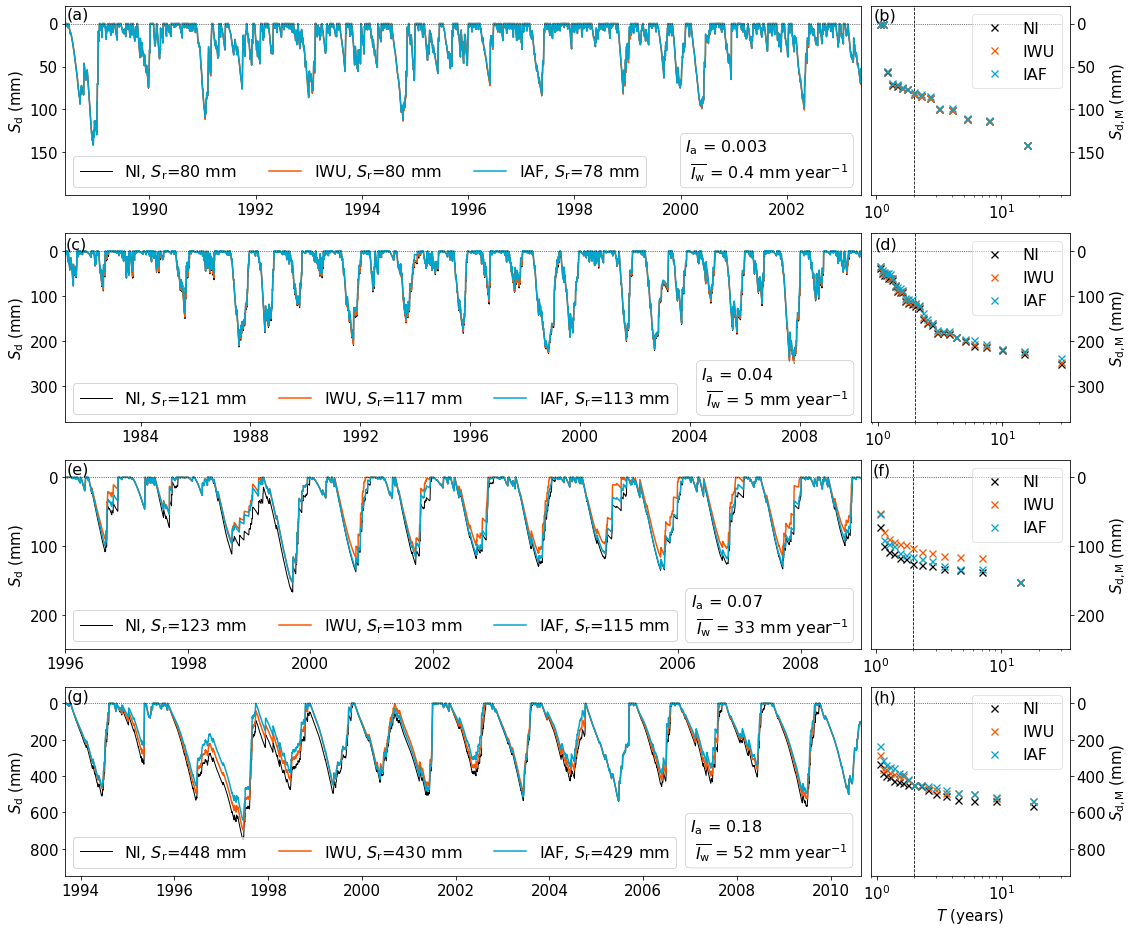

In [19]:
ir2 = pd.read_csv(f'{data_dir}/irrigation_data/combined_ia.csv',index_col=0) #read ia data

sr_df_ni = pd.read_csv(f'{data_dir}/sr/sr_no_irri_combined_points_rzyear.csv', index_col=0)
sr_df_f09ia = pd.read_csv(f'{data_dir}/sr/sr_irri_f0.9ia_combined_points2_rzyear_v2.csv', index_col=0)
sr_df_fiwu2 = pd.read_csv(f'{data_dir}/sr/sr_irri_fiwu2_combined_points2_rzyear_v2.csv', index_col=0)

#South-America
catch_id = ca0
region = f'{catch_id} (South-America)'
sd_f0 = pd.read_csv(f'{data_dir}/sd_timeseries/{catch_id}.csv',index_col=0)
sd_fiwu = pd.read_csv(f'{data_dir}/sd_timeseries/{catch_id}_fiwu2.csv',index_col=0)
sd_fopt = pd.read_csv(f'{data_dir}/sd_timeseries/{catch_id}_f0.9ia.csv',index_col=0)
sd_f0.index = pd.to_datetime(sd_f0.index)
sd_fiwu.index = pd.to_datetime(sd_fiwu.index)
sd_fopt.index = pd.to_datetime(sd_fopt.index)    

sr_df = pd.DataFrame(index=sr_df_ni.index)
sr_f0 = int(sr_df_ni['k3'].loc[catch_id])
sr_fiwu = int(sr_df_fiwu2['k3'].loc[catch_id])
sr_fopt = int(sr_df_f09ia['k3'].loc[catch_id])

iwu = pd.read_csv(f'{data_dir}/irrigation_data/{catch_id}.csv',index_col=0) # read iwu data
iwu_mean = np.round((iwu.mean().values[0]*365),1) # annual mean IWU
ir_area = np.round(ir2.loc[catch_id].hi,3) # irrigated area fraction 

fig, ax = plt.subplots(nrows=4,ncols=2,figsize=(18,16),gridspec_kw={'width_ratios': [4, 1],'hspace': 0.2,'wspace':0.02})
ax[0,0].plot(sd_f0.index,sd_f0.Sd,color='black',linestyle='-', label='NI, $S_\mathrm{r}$='+str(sr_f0)+' mm',linewidth=1)
ax[0,0].plot(sd_fiwu.index,sd_fiwu.sd2, color=c3, label='IWU, $S_\mathrm{r}$='+str(sr_fiwu)+' mm',linewidth=1.5)
ax[0,0].plot(sd_fopt.index,sd_fopt.sd2, color=c2, label='IAF, $S_\mathrm{r}$='+str(sr_fopt)+' mm',linewidth=1.5)
ax[0,0].hlines(0,sd_f0.index[0],sd_f0.index[-10],color='k',linestyle=':',linewidth=0.7)
ax[0,0].set_xlim(sd_f0.index[0],sd_f0.index[-10])
ax[0,0].annotate('(a)',(sd_f0.index[0]+timedelta(days=10),6),size=16)
ax[0,0].set_ylim(-200,20)
ax[0,0].set_yticks([-150,-100,-50,0])
ax[0,0].set_yticklabels([150,100,50,0])
ax[0,0].set_ylabel('$S_\mathrm{d}$ (mm)', size=15)
ax[0,0].tick_params(axis='both', labelsize=15)
ax[0,0].legend(ncol=3, fontsize=16, loc='lower left')
textstr = '\n'.join((
    '$I_\mathrm{a}$ = '+str(ir_area),
    ' $\overline{I_\mathrm{w}}$ = '+str(iwu_mean)+' $\mathrm{mm}$ $\mathrm{year}^{-1}$'))
props = dict(boxstyle='round', facecolor='white', alpha=0.5, linewidth=0.3)
ax[0,0].text('2000-02-01', -133, textstr, fontsize=16,verticalalignment='top', bbox=props)

#North-America
catch_id = ca1
region = f'{catch_id} (North-America)'
sd_f0 = pd.read_csv(f'{data_dir}/sd_timeseries/{catch_id}.csv',index_col=0)
sd_fiwu = pd.read_csv(f'{data_dir}/sd_timeseries/{catch_id}_fiwu2.csv',index_col=0)
sd_fopt = pd.read_csv(f'{data_dir}/sd_timeseries/{catch_id}_f0.9ia.csv',index_col=0)
sd_f0.index = pd.to_datetime(sd_f0.index)
sd_fiwu.index = pd.to_datetime(sd_fiwu.index)
sd_fopt.index = pd.to_datetime(sd_fopt.index)    

sr_df = pd.DataFrame(index=sr_df_ni.index)
sr_f0 = int(sr_df_ni['k3'].loc[catch_id])
sr_fiwu = int(sr_df_fiwu2['k3'].loc[catch_id])
sr_fopt = int(sr_df_f09ia['k3'].loc[catch_id])

iwu = pd.read_csv(f'{data_dir}/irrigation_data/{catch_id}.csv',index_col=0) # read iwu data
iwu_mean = np.int(iwu.mean().values[0]*365) # annual mean IWU
ir_area = np.round(ir2.loc[catch_id].hi,2) # irrigated area fraction 

ax[1,0].plot(sd_f0.index,sd_f0.Sd,color='black',linestyle='-', label='NI, $S_\mathrm{r}$='+str(sr_f0)+' mm',linewidth=1)
ax[1,0].plot(sd_fiwu.index,sd_fiwu.sd2, color=c3, label='IWU, $S_\mathrm{r}$='+str(sr_fiwu)+' mm',linewidth=1.5)
ax[1,0].plot(sd_fopt.index,sd_fopt.sd2, color=c2, label='IAF, $S_\mathrm{r}$='+str(sr_fopt)+' mm',linewidth=1.5)
ax[1,0].hlines(0,sd_f0.index[0],sd_f0.index[-10],color='k',linestyle=':',linewidth=0.7)
ax[1,0].set_xlim(sd_f0.index[0],sd_f0.index[-10])
ax[1,0].annotate('(c)',(sd_f0.index[0]+timedelta(days=10),6),size=16)
ax[1,0].set_ylim(-380,40)
ax[1,0].set_yticks([-300,-200,-100,0])
ax[1,0].set_yticklabels([300,200,100,0])
ax[1,0].set_ylabel('$S_\mathrm{d}$ (mm)', size=15)
ax[1,0].tick_params(axis='both', labelsize=15)
ax[1,0].legend(ncol=3, fontsize=16, loc='lower left')
textstr = '\n'.join((
    '$I_\mathrm{a}$ = '+str(ir_area),
    ' $\overline{I_\mathrm{w}}$ = '+str(iwu_mean)+' $\mathrm{mm}$ $\mathrm{year}^{-1}$'))
props = dict(boxstyle='round', facecolor='white', alpha=0.5, linewidth=0.3)
ax[1,0].text('2004-06-01', -253, textstr, fontsize=16,verticalalignment='top', bbox=props)

#Europe
catch_id = ca2
region = f'{catch_id} (Europe)'
sd_f0 = pd.read_csv(f'{data_dir}/sd_timeseries/{catch_id}.csv',index_col=0)
sd_fiwu = pd.read_csv(f'{data_dir}/sd_timeseries/{catch_id}_fiwu2.csv',index_col=0)
sd_fopt = pd.read_csv(f'{data_dir}/sd_timeseries/{catch_id}_f0.9ia.csv',index_col=0)
sd_f0.index = pd.to_datetime(sd_f0.index)
sd_fiwu.index = pd.to_datetime(sd_fiwu.index)
sd_fopt.index = pd.to_datetime(sd_fopt.index)    

sr_df = pd.DataFrame(index=sr_df_ni.index)
sr_f0 = int(sr_df_ni['k3'].loc[catch_id])
sr_fiwu = int(sr_df_fiwu2['k3'].loc[catch_id])
sr_fopt = int(sr_df_f09ia['k3'].loc[catch_id])

iwu = pd.read_csv(f'{data_dir}/irrigation_data/{catch_id}.csv',index_col=0) # read iwu data
iwu_mean = np.int(iwu.mean().values[0]*365) # annual mean IWU
ir_area = np.round(ir2.loc[catch_id].hi,2) # irrigated area fraction 

ax[2,0].plot(sd_f0.index,sd_f0.Sd,color='black',linestyle='-', label='NI, $S_\mathrm{r}$='+str(sr_f0)+' mm',linewidth=1)
ax[2,0].plot(sd_fiwu.index,sd_fiwu.sd2, color=c3, label='IWU, $S_\mathrm{r}$='+str(sr_fiwu)+' mm',linewidth=1.5)
ax[2,0].plot(sd_fopt.index,sd_fopt.sd2, color=c2, label='IAF, $S_\mathrm{r}$='+str(sr_fopt)+' mm',linewidth=1.5)
ax[2,0].hlines(0,sd_f0.index[0],sd_f0.index[-10],color='k',linestyle=':',linewidth=0.7)
ax[2,0].set_xlim(sd_f0.index[0],sd_f0.index[-10])
ax[2,0].annotate('(e)',(sd_f0.index[0]+timedelta(days=10),6),size=16)
ax[2,0].set_ylim(-250,25)
ax[2,0].set_yticks([-200,-100,0])
ax[2,0].set_yticklabels([200,100,0])
ax[2,0].set_ylabel('$S_\mathrm{d}$ (mm)', size=15)
ax[2,0].tick_params(axis='both', labelsize=15)
ax[2,0].legend(ncol=3, fontsize=16, loc='lower left')
textstr = '\n'.join((
    '$I_\mathrm{a}$ = '+str(ir_area),
    ' $\overline{I_\mathrm{w}}$ = '+str(iwu_mean)+' $\mathrm{mm}$ $\mathrm{year}^{-1}$'))
props = dict(boxstyle='round', facecolor='white', alpha=0.5, linewidth=0.3)
ax[2,0].text('2006-03-15', -168, textstr, fontsize=16,verticalalignment='top', bbox=props)

#Asia
catch_id = ca3
region = f'{catch_id} (Asia)'
sd_f0 = pd.read_csv(f'{data_dir}/sd_timeseries/{catch_id}.csv',index_col=0)
sd_fiwu = pd.read_csv(f'{data_dir}/sd_timeseries/{catch_id}_fiwu2.csv',index_col=0)
sd_fopt = pd.read_csv(f'{data_dir}/sd_timeseries/{catch_id}_f0.9ia.csv',index_col=0)
sd_f0.index = pd.to_datetime(sd_f0.index)
sd_fiwu.index = pd.to_datetime(sd_fiwu.index)
sd_fopt.index = pd.to_datetime(sd_fopt.index)    

sr_df = pd.DataFrame(index=sr_df_ni.index)
sr_f0 = int(sr_df_ni['k3'].loc[catch_id])
sr_fiwu = int(sr_df_fiwu2['k3'].loc[catch_id])
sr_fopt = int(sr_df_f09ia['k3'].loc[catch_id])

iwu = pd.read_csv(f'{data_dir}/irrigation_data/{catch_id}.csv',index_col=0) # read iwu data
iwu_mean = np.int(iwu.mean().values[0]*365) # annual mean IWU
ir_area = np.round(ir2.loc[catch_id].hi,2) # irrigated area fraction 

ax[3,0].plot(sd_f0.index,sd_f0.Sd,color='black',linestyle='-', label='NI, $S_\mathrm{r}$='+str(sr_f0)+' mm',linewidth=1)
ax[3,0].plot(sd_fiwu.index,sd_fiwu.sd2, color=c3, label='IWU, $S_\mathrm{r}$='+str(sr_fiwu)+' mm',linewidth=1.5)
ax[3,0].plot(sd_fopt.index,sd_fopt.sd2, color=c2, label='IAF, $S_\mathrm{r}$='+str(sr_fopt)+' mm',linewidth=1.5)
ax[3,0].hlines(0,sd_f0.index[0],sd_f0.index[-10],color='k',linestyle=':',linewidth=0.7)
ax[3,0].set_xlim(sd_f0.index[0],sd_f0.index[-10])
ax[3,0].annotate('(g)',(sd_f0.index[0]+timedelta(days=10),10),size=16)
ax[3,0].set_ylim(-950,90)
ax[3,0].set_yticks([-800,-600,-400,-200,0])
ax[3,0].set_yticklabels([800,600,400,200,0])
ax[3,0].set_ylabel('$S_\mathrm{d}$ (mm)', size=15)
ax[3,0].tick_params(axis='both', labelsize=15)
ax[3,0].legend(ncol=3, fontsize=16, loc='lower left')
textstr = '\n'.join((
    '$I_\mathrm{a}$ = '+str(ir_area),
    ' $\overline{I_\mathrm{w}}$ = '+str(iwu_mean)+' $\mathrm{mm}$ $\mathrm{year}^{-1}$'))
props = dict(boxstyle='round', facecolor='white', alpha=0.5, linewidth=0.3)
ax[3,0].text('2007-01-01', -630, textstr, fontsize=16,verticalalignment='top', bbox=props)

# plot gumbel distribution
ca=ca0
d1 = pd.read_csv(f'{data_dir}/sr/{ca}_points.csv',index_col=0)
d2 = pd.read_csv(f'{data_dir}/sr/{ca}_fiwu2_points.csv',index_col=0)
d3 = pd.read_csv(f'{data_dir}/sr/{ca}_f0.9ia_points.csv',index_col=0)
ax[0,1].vlines(2,-350,350,'k',linestyle='--',linewidth=0.8)
ax[0,1].hlines(0,0,30,color='k',linestyle=':',linewidth=0.7)
ax[0,1].plot(d1['T_a'], d1['sd']*-1,'x',color='k', markersize=7,markeredgewidth=1.3, label='NI')
ax[0,1].plot(d2['T_a'], d2['sd']*-1,'x',color=c3, markersize=7,markeredgewidth=1.3, label='IWU')
ax[0,1].plot(d3['T_a'], d3['sd']*-1,'x',color=c2, markersize=7,markeredgewidth=1.3, label='IAF')
ax[0,1].annotate('(b)',(0.95,4),size=16)
ax[0,1].set_ylim(-200,20)
ax[0,1].set_yticks([-150,-100,-50,0])
ax[0,1].set_yticklabels([150,100,50,0])
ax[0,1].set_ylabel('$S_\mathrm{d,M}$ (mm)', size=15)
ax[0,1].tick_params(axis='both', labelsize=15)
ax[0,1].set_xscale('log')
ax[0,1].set_xlim(0,35)
ax[0,1].yaxis.tick_right()
ax[0,1].yaxis.set_label_position("right")
ax[0,1].legend(loc='upper right',framealpha=0.5,fontsize=16)

ca=ca1
d1 = pd.read_csv(f'{data_dir}/sr/{ca}_points.csv',index_col=0)
d2 = pd.read_csv(f'{data_dir}/sr/{ca}_fiwu2_points.csv',index_col=0)
d3 = pd.read_csv(f'{data_dir}/sr/{ca}_f0.9ia_points.csv',index_col=0)
ax[1,1].vlines(2,-390,350,'k',linestyle='--',linewidth=0.8)
ax[1,1].hlines(0,0,30,color='k',linestyle=':',linewidth=0.7)
ax[1,1].plot(d1['T_a'], d1['sd']*-1,'x',color='k', markersize=7,markeredgewidth=1.3, label='NI')
ax[1,1].plot(d2['T_a'], d2['sd']*-1,'x',color=c3, markersize=7,markeredgewidth=1.3, label='IWU')
ax[1,1].plot(d3['T_a'], d3['sd']*-1,'x',color=c2, markersize=7,markeredgewidth=1.3, label='IAF')
ax[1,1].annotate('(d)',(0.95,6),size=16)
ax[1,1].set_ylim(-380,40)
ax[1,1].set_yticks([-300,-200,-100,0])
ax[1,1].set_yticklabels([300,200,100,0])
ax[1,1].set_ylabel('$S_\mathrm{d,M}$ (mm)', size=15)
ax[1,1].tick_params(axis='both', labelsize=15)
ax[1,1].set_xscale('log')
ax[1,1].set_xlim(0,35)
ax[1,1].yaxis.tick_right()
ax[1,1].yaxis.set_label_position("right")
ax[1,1].legend(loc='upper right',framealpha=0.5,fontsize=16)

ca=ca2
d1 = pd.read_csv(f'{data_dir}/sr/{ca}_points.csv',index_col=0)
d2 = pd.read_csv(f'{data_dir}/sr/{ca}_fiwu2_points.csv',index_col=0)
d3 = pd.read_csv(f'{data_dir}/sr/{ca}_f0.9ia_points.csv',index_col=0)
ax[2,1].vlines(2,-350,350,'k',linestyle='--',linewidth=0.8)
ax[2,1].hlines(0,0,30,color='k',linestyle=':',linewidth=0.7)
ax[2,1].plot(d1['T_a'], d1['sd']*-1,'x',color='k', markersize=7,markeredgewidth=1.3, label='NI')
ax[2,1].plot(d2['T_a'], d2['sd']*-1,'x',color=c3, markersize=7,markeredgewidth=1.3, label='IWU')
ax[2,1].plot(d3['T_a'], d3['sd']*-1,'x',color=c2, markersize=7,markeredgewidth=1.3, label='IAF')
ax[2,1].annotate('(f)',(0.95,4),size=16)
ax[2,1].set_ylim(-250,25)
ax[2,1].set_yticks([-200,-100,0])
ax[2,1].set_yticklabels([200,100,0])
ax[2,1].set_ylabel('$S_\mathrm{d,M}$ (mm)', size=15)
ax[2,1].tick_params(axis='both', labelsize=15)
ax[2,1].set_xscale('log')
ax[2,1].set_xlim(0,35)
ax[2,1].yaxis.tick_right()
ax[2,1].yaxis.set_label_position("right")
ax[2,1].legend(loc='upper right',framealpha=0.5,fontsize=16)

ca=ca3
d1 = pd.read_csv(f'{data_dir}/sr/{ca}_points.csv',index_col=0)
d2 = pd.read_csv(f'{data_dir}/sr/{ca}_fiwu2_points.csv',index_col=0)
d3 = pd.read_csv(f'{data_dir}/sr/{ca}_f0.9ia_points.csv',index_col=0)
ax[3,1].vlines(2,-950,350,'k',linestyle='--',linewidth=0.8)
ax[3,1].hlines(0,0,30,color='k',linestyle=':',linewidth=0.7)
ax[3,1].plot(d1['T_a'], d1['sd']*-1,'x',color='k', markersize=7,markeredgewidth=1.3, label='NI')
ax[3,1].plot(d2['T_a'], d2['sd']*-1,'x',color=c3, markersize=7,markeredgewidth=1.3, label='IWU')
ax[3,1].plot(d3['T_a'], d3['sd']*-1,'x',color=c2, markersize=7,markeredgewidth=1.3, label='IAF')
ax[3,1].annotate('(h)',(0.95,10),size=16)
ax[3,1].set_ylim(-950,90)
ax[3,1].set_yticks([-800,-600,-400,-200,0])
ax[3,1].set_yticklabels([800,600,400,200,0])
ax[3,1].set_xlabel('$T$ (years)',size=15)
ax[3,1].set_ylabel('$S_\mathrm{d,M}$ (mm)', size=15)
ax[3,1].tick_params(axis='both', labelsize=15)
ax[3,1].set_xscale('log')
ax[3,1].set_xlim(0,35)
ax[3,1].yaxis.tick_right()
ax[3,1].legend(loc='upper right',framealpha=0.5,fontsize=16)
ax[3,1].yaxis.set_label_position("right")
fig.savefig(f'{fig_dir}/timeseries_sd_gumbel2.jpg', dpi=300, bbox_inches='tight')


## SR PLOTS

In [20]:
# combine Sr output in dataframe
sr_df_ni = pd.read_csv(f'{data_dir}/sr/sr_no_irri_combined_points_rzyear.csv', index_col=0)
sr_df_f09ia = pd.read_csv(f'{data_dir}/sr/sr_irri_f0.9ia_combined_points2_rzyear_v2.csv', index_col=0)
sr_df_fiwu2 = pd.read_csv(f'{data_dir}/sr/sr_irri_fiwu2_combined_points2_rzyear_v2.csv', index_col=0)

sr_df = pd.DataFrame(index=sr_df_ni.index)
sr_df['sr_2_f0'] = sr_df_ni['k3']
sr_df['sr_2_fiwu'] = sr_df_fiwu2['k3']
sr_df['sr_2_fopt'] = sr_df_f09ia['k3']

sr_df = sr_df.dropna()
sr_df = sr_df.astype(int) #int values
                
# dataframes with errors
f0_iwu_e = np.round(sr_df.sr_2_fiwu-sr_df.sr_2_f0,3)
f0_opt_e = np.round(sr_df.sr_2_fopt-sr_df.sr_2_f0,3)
fopt_iwu_e = np.round(sr_df.sr_2_fiwu-sr_df.sr_2_fopt,3)

f0_iwu_er = np.round((sr_df.sr_2_fiwu-sr_df.sr_2_f0)/sr_df.sr_2_f0 ,4)
f0_opt_er = np.round((sr_df.sr_2_fopt-sr_df.sr_2_f0)/sr_df.sr_2_f0 ,4)
fopt_iwu_er = np.round((sr_df.sr_2_fiwu-sr_df.sr_2_fopt)/sr_df.sr_2_fopt ,4) 

e_df = pd.DataFrame(index=sr_df.index, columns=['f0_fiwu','f0_fopt','fopt_fiwu'])
e_df['f0_fiwu'] = f0_iwu_e
e_df['f0_fopt'] = f0_opt_e
e_df['fopt_fiwu'] = fopt_iwu_e

er_df = pd.DataFrame(index=sr_df.index, columns=['f0_fiwu','f0_fopt','fopt_fiwu'])
er_df['f0_fiwu'] = f0_iwu_er
er_df['f0_fopt'] = f0_opt_er
er_df['fopt_fiwu'] = fopt_iwu_er

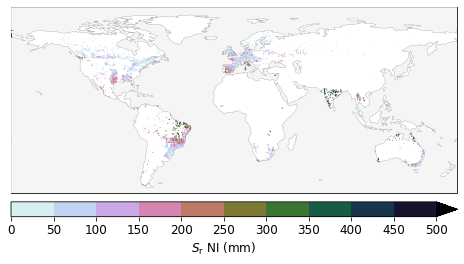

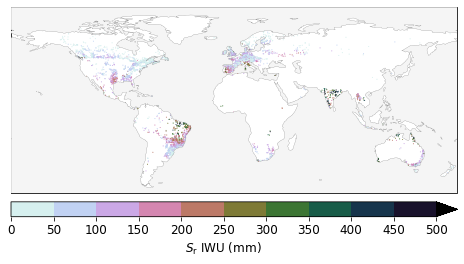

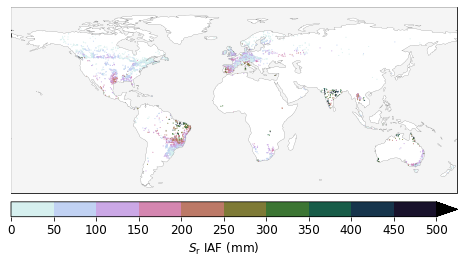

In [21]:
c = pd.read_csv(f'{data_dir}/catchment_characteristics_gswp-p_gleam-ep_gswp-t.csv',index_col=0)

cmap_vd2 = cmap_sr

sr_df['lat'] = c.lat
sr_df['lon'] = c.lon

bounds = np.linspace(0,500,11)
bounds2 = np.linspace(0,500,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap_vd2.N)

# no irrigation
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.001)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.12)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(sr_df.lon,sr_df.lat,s=0.8,c=sr_df['sr_2_f0'],cmap=cmap_vd2, norm=norm,edgecolors='face',marker='o',linewidths=0.1)
cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='max', pad=0.02,aspect=30, norm=norm,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='$S_\mathrm{r}$ NI (mm)', size=12)
ax.set_title('',size=14)
fig.savefig(f'{fig_dir}/sr_map_T2_irrigation_NI.jpg',bbox_inches='tight',dpi=600)

# irrigation fiwu
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.001)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.12)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(sr_df.lon,sr_df.lat,c=sr_df['sr_2_fiwu'],s=0.8,cmap=cmap_vd2, norm=norm,edgecolors='face',marker='o',linewidths=0.1)
cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='max', pad=0.02,aspect=30, norm=norm,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='$S_\mathrm{r}$ IWU (mm)', size=12)
fig.savefig(f'{fig_dir}/sr_map_T2_irrigation_IWU.jpg',bbox_inches='tight',dpi=300)

# irrigation fopt
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.001)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.12)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(sr_df.lon,sr_df.lat,c=sr_df['sr_2_fopt'],s=0.8,cmap=cmap_vd2, norm=norm,edgecolors='face',marker='o',linewidths=0.1)
cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='max', pad=0.02,aspect=30, norm=norm,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='$S_\mathrm{r}$ IAF (mm)', size=12)
fig.savefig(f'{fig_dir}/sr_map_T2_irrigation_IAF.jpg',bbox_inches='tight',dpi=300)

k3     70.963361
k5     70.584678
lat    50.797900
lon     4.589600
dtype: float64


Text(0.5, 1.0, '')

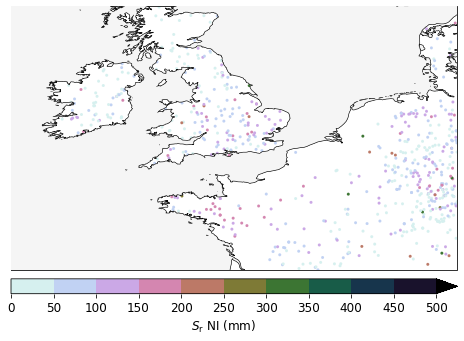

In [22]:
# western europe
lat_min_we, lat_max_we = 45,58
lon_min_we, lon_max_we = -12,10

sr_df_ni['lat'] = c.lat
sr_df_ni['lon'] = c.lon

sr_df_ni_we = sr_df_ni[(sr_df_ni.lat<lat_max_we)&(sr_df_ni.lat>lat_min_we)&(sr_df_ni.lon<lon_max_we)&(sr_df_ni.lon>lon_min_we)]
print(sr_df_ni_we.median())

# no irrigation
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.2)
ax.set_global()
ax.set_xlim(lon_min_we,lon_max_we)
ax.set_ylim(lat_min_we,lat_max_we)
s = ax.scatter(sr_df_ni_we.lon,sr_df_ni_we.lat,s=8,c=sr_df_ni_we['k3'],cmap=cmap_vd2, norm=norm,edgecolors='face',marker='o',linewidths=0.1)
cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='max', pad=0.02,aspect=30, norm=norm,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='$S_\mathrm{r}$ NI (mm)', size=12)
ax.set_title('',size=14)


k3     39.605593
k5     39.387654
lat    46.893700
lon   -81.014600
dtype: float64


Text(0.5, 1.0, '')

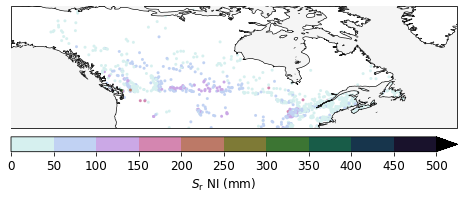

In [23]:
# canada
lat_min_we, lat_max_we = 40,70
lon_min_we, lon_max_we = -150,-40

sr_df_ni['lat'] = c.lat
sr_df_ni['lon'] = c.lon

sr_df_ni_we = sr_df_ni[(sr_df_ni.lat<lat_max_we)&(sr_df_ni.lat>lat_min_we)&(sr_df_ni.lon<lon_max_we)&(sr_df_ni.lon>lon_min_we)]
print(sr_df_ni_we.median())

# no irrigation
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.2)
ax.set_global()
ax.set_xlim(lon_min_we,lon_max_we)
ax.set_ylim(lat_min_we,lat_max_we)
s = ax.scatter(sr_df_ni_we.lon,sr_df_ni_we.lat,s=8,c=sr_df_ni_we['k3'],cmap=cmap_vd2, norm=norm,edgecolors='face',marker='o',linewidths=0.1)
cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='max', pad=0.02,aspect=30, norm=norm,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='$S_\mathrm{r}$ NI (mm)', size=12)
ax.set_title('',size=14)

k3     245.939183
k5     246.087780
lat     -7.206300
lon    -37.285400
dtype: float64


Text(0.5, 1.0, '')

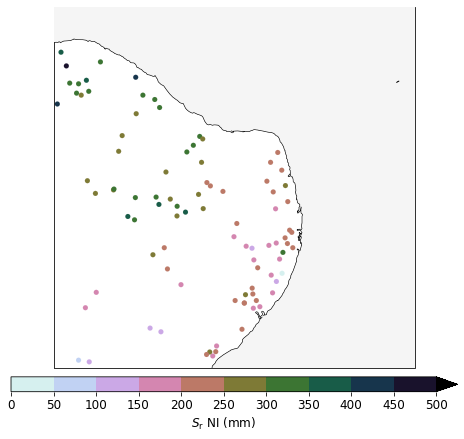

In [24]:
# NE brazil
lat_min_we, lat_max_we = -11,-2
lon_min_we, lon_max_we = -41,-32

sr_df_ni['lat'] = c.lat
sr_df_ni['lon'] = c.lon

sr_df_ni_we = sr_df_ni[(sr_df_ni.lat<lat_max_we)&(sr_df_ni.lat>lat_min_we)&(sr_df_ni.lon<lon_max_we)&(sr_df_ni.lon>lon_min_we)]
print(sr_df_ni_we.median())

# no irrigation
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.2)
ax.set_global()
ax.set_xlim(lon_min_we,lon_max_we)
ax.set_ylim(lat_min_we,lat_max_we)
s = ax.scatter(sr_df_ni_we.lon,sr_df_ni_we.lat,s=25,c=sr_df_ni_we['k3'],cmap=cmap_vd2, norm=norm,edgecolors='face',marker='o',linewidths=0.1)
cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='max', pad=0.02,aspect=30, norm=norm,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='$S_\mathrm{r}$ NI (mm)', size=12)
ax.set_title('',size=14)

k3     436.259635
k5     436.049516
lat     21.443750
lon     82.218700
dtype: float64


Text(0.5, 1.0, '')

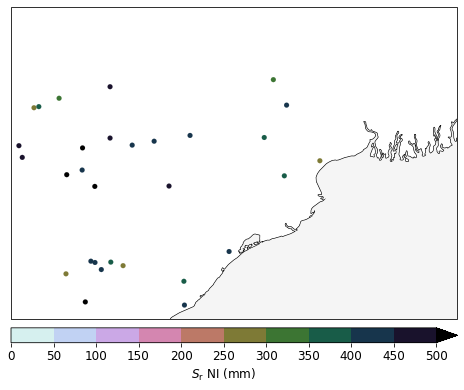

In [25]:
# India
lat_min_we, lat_max_we = 18,25
lon_min_we, lon_max_we = 80,90

sr_df_ni['lat'] = c.lat
sr_df_ni['lon'] = c.lon

sr_df_ni_we = sr_df_ni[(sr_df_ni.lat<lat_max_we)&(sr_df_ni.lat>lat_min_we)&(sr_df_ni.lon<lon_max_we)&(sr_df_ni.lon>lon_min_we)]
print(sr_df_ni_we.median())

# no irrigation
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.2)
ax.set_global()
ax.set_xlim(lon_min_we,lon_max_we)
ax.set_ylim(lat_min_we,lat_max_we)
s = ax.scatter(sr_df_ni_we.lon,sr_df_ni_we.lat,s=25,c=sr_df_ni_we['k3'],cmap=cmap_vd2, norm=norm,edgecolors='face',marker='o',linewidths=0.1)
cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='max', pad=0.02,aspect=30, norm=norm,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='$S_\mathrm{r}$ NI (mm)', size=12)
ax.set_title('',size=14)

k3     350.394053
k5     350.197715
lat    -14.463333
lon    142.637778
dtype: float64


Text(0.5, 1.0, '')

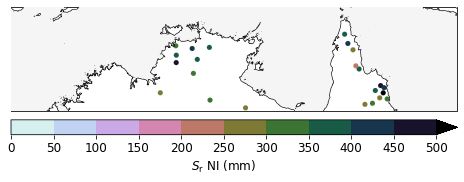

In [26]:
# Northern Australia
lat_min_we, lat_max_we = -17,-10
lon_min_we, lon_max_we = 120,150

sr_df_ni['lat'] = c.lat
sr_df_ni['lon'] = c.lon

sr_df_ni_we = sr_df_ni[(sr_df_ni.lat<lat_max_we)&(sr_df_ni.lat>lat_min_we)&(sr_df_ni.lon<lon_max_we)&(sr_df_ni.lon>lon_min_we)]
print(sr_df_ni_we.median())

# no irrigation
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.2)
ax.set_global()
ax.set_xlim(lon_min_we,lon_max_we)
ax.set_ylim(lat_min_we,lat_max_we)
s = ax.scatter(sr_df_ni_we.lon,sr_df_ni_we.lat,s=25,c=sr_df_ni_we['k3'],cmap=cmap_vd2, norm=norm,edgecolors='face',marker='o',linewidths=0.1)
cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='max', pad=0.02,aspect=30, norm=norm,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='$S_\mathrm{r}$ NI (mm)', size=12)
ax.set_title('',size=14)

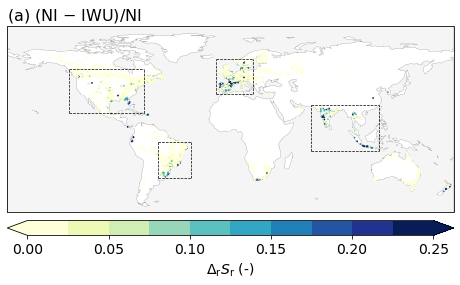

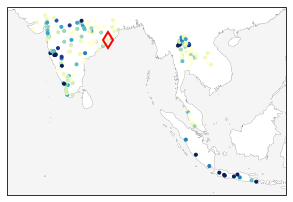

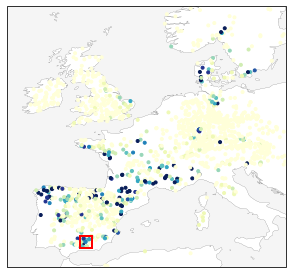

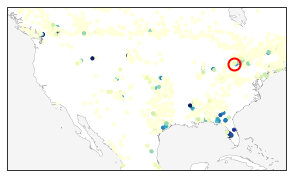

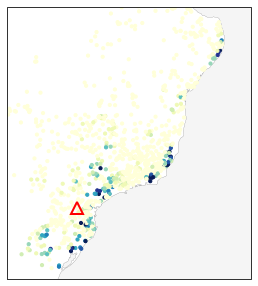

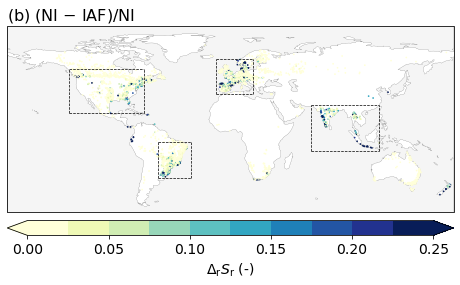

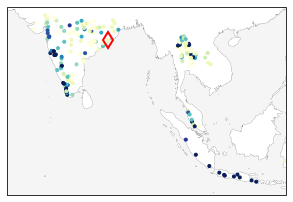

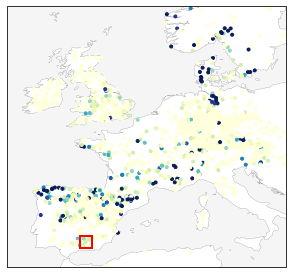

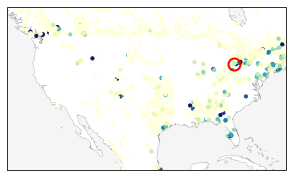

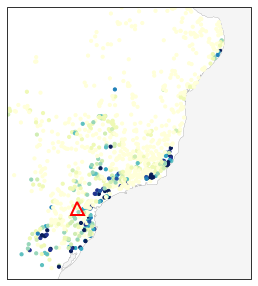

In [27]:
# RELATIVE DIFFERENCES IN SR
c = pd.read_csv(f'{data_dir}/catchment_characteristics_gswp-p_gleam-ep_gswp-t.csv',index_col=0)

er_df['lat'] = c.lat
er_df['lon'] = c.lon

er_df_a = er_df[(er_df.lat<lat_max_a)&(er_df.lat>lat_min_a)&(er_df.lon<lon_max_a)&(er_df.lon>lon_min_a)]
er_df_e = er_df[(er_df.lat<lat_max_e)&(er_df.lat>lat_min_e)&(er_df.lon<lon_max_e)&(er_df.lon>lon_min_e)]
er_df_u = er_df[(er_df.lat<lat_max_u)&(er_df.lat>lat_min_u)&(er_df.lon<lon_max_u)&(er_df.lon>lon_min_u)]
er_df_s = er_df[(er_df.lat<lat_max_s)&(er_df.lat>lat_min_s)&(er_df.lon<lon_max_s)&(er_df.lon>lon_min_s)]

bounds = np.linspace(0,0.25,11)
bounds2 = np.linspace(0.0,0.25,6)
norm = mpl.colors.BoundaryNorm(bounds, cmap_ylgnbu.N)

# no irrigation vs fiwu
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.001)
ax.add_feature(cartopy.feature.OCEAN, zorder=1,facecolor='whitesmoke', edgecolor='k',linewidth=0.12)
ax.set_global()

ax.plot([lon_min_a,lon_max_a],[lat_max_a,lat_max_a],'k--',zorder=3,linewidth=0.7)
ax.plot([lon_min_a,lon_max_a],[lat_min_a,lat_min_a],'k--',zorder=3,linewidth=0.7)
ax.plot([lon_min_a,lon_min_a],[lat_min_a,lat_max_a],'k--',zorder=3,linewidth=0.7)
ax.plot([lon_max_a,lon_max_a],[lat_min_a,lat_max_a],'k--',zorder=3,linewidth=0.7)

ax.plot([lon_min_e,lon_max_e],[lat_max_e,lat_max_e],'k--',zorder=3,linewidth=0.7)
ax.plot([lon_min_e,lon_max_e],[lat_min_e,lat_min_e],'k--',zorder=3,linewidth=0.7)
ax.plot([lon_min_e,lon_min_e],[lat_min_e,lat_max_e],'k--',zorder=3,linewidth=0.7)
ax.plot([lon_max_e,lon_max_e],[lat_min_e,lat_max_e],'k--',zorder=3,linewidth=0.7)

ax.plot([lon_min_u,lon_max_u],[lat_max_u,lat_max_u],'k--',zorder=3,linewidth=0.7)
ax.plot([lon_min_u,lon_max_u],[lat_min_u,lat_min_u],'k--',zorder=3,linewidth=0.7)
ax.plot([lon_min_u,lon_min_u],[lat_min_u,lat_max_u],'k--',zorder=3,linewidth=0.7)
ax.plot([lon_max_u,lon_max_u],[lat_min_u,lat_max_u],'k--',zorder=3,linewidth=0.7)

ax.plot([lon_min_s,lon_max_s],[lat_max_s,lat_max_s],'k--',zorder=3,linewidth=0.7)
ax.plot([lon_min_s,lon_max_s],[lat_min_s,lat_min_s],'k--',zorder=3,linewidth=0.7)
ax.plot([lon_min_s,lon_min_s],[lat_min_s,lat_max_s],'k--',zorder=3,linewidth=0.7)
ax.plot([lon_max_s,lon_max_s],[lat_min_s,lat_max_s],'k--',zorder=3,linewidth=0.7)

ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(sr_df.lon,sr_df.lat,c=er_df['f0_fiwu']*-1,s=0.5,cmap=cmap_ylgnbu,norm=norm,zorder=2)
cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='both', pad=0.02,norm=norm,ticks=bounds2,aspect=30)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(label='$\Delta_\mathrm{r} S_\mathrm{r}$ (-)', size=14)
ax.set_title('(a) (NI $-$ IWU)/NI',loc='left',size=16)
fig.savefig(f'{fig_dir}/srreldiff_map_T2_no_irrigation_fiwu.jpg',bbox_inches='tight',dpi=300)

# asia
fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.001)
ax.add_feature(cartopy.feature.OCEAN, zorder=1,facecolor='whitesmoke', edgecolor='k',linewidth=0.12)
ax.set_global()
ax.set_xlim(lon_min_a,lon_max_a)
ax.set_ylim(lat_min_a,lat_max_a)
s = ax.scatter(er_df.lon,er_df.lat,c=er_df['f0_fiwu']*-1,s=9,cmap=cmap_ylgnbu,norm=norm,zorder=2)
ax.plot(er_df.loc[ca3]['lon'],er_df.loc[ca3]['lat'],'d',markeredgecolor='red',markeredgewidth=2,markerfacecolor='None',markersize=12)
fig.savefig(f'{fig_dir}/srreldiff_map_T2_no_irrigation_fiwu_asia.jpg',bbox_inches='tight',dpi=300)

# EUROPE
fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.001)
ax.add_feature(cartopy.feature.OCEAN, zorder=1,facecolor='whitesmoke', edgecolor='k',linewidth=0.12)
ax.set_global()
ax.set_xlim(lon_min_e,lon_max_e)
ax.set_ylim(lat_min_e,lat_max_e)
s = ax.scatter(sr_df.lon,sr_df.lat,c=er_df['f0_fiwu']*-1,s=9,cmap=cmap_ylgnbu,norm=norm,zorder=2)
ax.plot(er_df.loc[ca2]['lon'],er_df.loc[ca2]['lat'],'s',markeredgecolor='red',markeredgewidth=2,markerfacecolor='None',markersize=12)
fig.savefig(f'{fig_dir}/srreldiff_map_T2_no_irrigation_fiwu_europe.jpg',bbox_inches='tight',dpi=300)

# USA
fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.001)
ax.add_feature(cartopy.feature.OCEAN, zorder=1,facecolor='whitesmoke', edgecolor='k',linewidth=0.12)
ax.set_global()
ax.set_xlim(lon_min_u,lon_max_u)
ax.set_ylim(lat_min_u,lat_max_u)
s = ax.scatter(sr_df.lon,sr_df.lat,c=er_df['f0_fiwu']*-1,s=10,cmap=cmap_ylgnbu,norm=norm,zorder=2)
ax.plot(er_df.loc[ca1]['lon'],er_df.loc[ca1]['lat'],'o',markeredgecolor='red',markeredgewidth=2,markerfacecolor='None',markersize=12)
fig.savefig(f'{fig_dir}/srreldiff_map_T2_no_irrigation_fiwu_us.jpg',bbox_inches='tight',dpi=300)

# SOUTH AMERICA
fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.001)
ax.add_feature(cartopy.feature.OCEAN, zorder=1,facecolor='whitesmoke', edgecolor='k',linewidth=0.12)
ax.set_global()
ax.set_xlim(lon_min_s,lon_max_s)
ax.set_ylim(lat_min_s,lat_max_s)
s = ax.scatter(sr_df.lon,sr_df.lat,c=er_df['f0_fiwu']*-1,s=10,cmap=cmap_ylgnbu,norm=norm,zorder=2)
ax.plot(er_df.loc[ca0]['lon'],er_df.loc[ca0]['lat'],'^',markeredgecolor='red',markeredgewidth=2,markerfacecolor='None',markersize=12)
fig.savefig(f'{fig_dir}/srreldiff_map_T2_no_irrigation_fiwu_sa.jpg',bbox_inches='tight',dpi=300)


# no irrigation vs fia
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.001)
ax.add_feature(cartopy.feature.OCEAN, zorder=1,facecolor='whitesmoke', edgecolor='k',linewidth=0.12)
ax.set_global()

ax.plot([lon_min_a,lon_max_a],[lat_max_a,lat_max_a],'k--',zorder=3,linewidth=0.7)
ax.plot([lon_min_a,lon_max_a],[lat_min_a,lat_min_a],'k--',zorder=3,linewidth=0.7)
ax.plot([lon_min_a,lon_min_a],[lat_min_a,lat_max_a],'k--',zorder=3,linewidth=0.7)
ax.plot([lon_max_a,lon_max_a],[lat_min_a,lat_max_a],'k--',zorder=3,linewidth=0.7)

ax.plot([lon_min_e,lon_max_e],[lat_max_e,lat_max_e],'k--',zorder=3,linewidth=0.7)
ax.plot([lon_min_e,lon_max_e],[lat_min_e,lat_min_e],'k--',zorder=3,linewidth=0.7)
ax.plot([lon_min_e,lon_min_e],[lat_min_e,lat_max_e],'k--',zorder=3,linewidth=0.7)
ax.plot([lon_max_e,lon_max_e],[lat_min_e,lat_max_e],'k--',zorder=3,linewidth=0.7)

ax.plot([lon_min_u,lon_max_u],[lat_max_u,lat_max_u],'k--',zorder=3,linewidth=0.7)
ax.plot([lon_min_u,lon_max_u],[lat_min_u,lat_min_u],'k--',zorder=3,linewidth=0.7)
ax.plot([lon_min_u,lon_min_u],[lat_min_u,lat_max_u],'k--',zorder=3,linewidth=0.7)
ax.plot([lon_max_u,lon_max_u],[lat_min_u,lat_max_u],'k--',zorder=3,linewidth=0.7)

ax.plot([lon_min_s,lon_max_s],[lat_max_s,lat_max_s],'k--',zorder=3,linewidth=0.7)
ax.plot([lon_min_s,lon_max_s],[lat_min_s,lat_min_s],'k--',zorder=3,linewidth=0.7)
ax.plot([lon_min_s,lon_min_s],[lat_min_s,lat_max_s],'k--',zorder=3,linewidth=0.7)
ax.plot([lon_max_s,lon_max_s],[lat_min_s,lat_max_s],'k--',zorder=3,linewidth=0.7)

ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(sr_df.lon,sr_df.lat,c=er_df['f0_fopt']*-1,s=0.5,cmap=cmap_ylgnbu,norm=norm,zorder=2)
cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='both', pad=0.02,norm=norm,ticks=bounds2,aspect=30)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(label='$\Delta_\mathrm{r} S_\mathrm{r}$ (-)', size=14)
ax.set_title('(b) (NI $-$ IAF)/NI',loc='left',size=16)
fig.savefig(f'{fig_dir}/srreldiff_map_T2_no_irrigation_fia.jpg',bbox_inches='tight',dpi=300)

# asia
fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.001)
ax.add_feature(cartopy.feature.OCEAN, zorder=1,facecolor='whitesmoke', edgecolor='k',linewidth=0.12)
ax.set_global()
ax.set_xlim(lon_min_a,lon_max_a)
ax.set_ylim(lat_min_a,lat_max_a)
s = ax.scatter(er_df.lon,er_df.lat,c=er_df['f0_fopt']*-1,s=9,cmap=cmap_ylgnbu,norm=norm,zorder=2)
ax.plot(er_df.loc[ca3]['lon'],er_df.loc[ca3]['lat'],'d',markeredgecolor='red',markeredgewidth=2,markerfacecolor='None',markersize=12)
fig.savefig(f'{fig_dir}/srreldiff_map_T2_no_irrigation_fia_asia.jpg',bbox_inches='tight',dpi=300)

# EUROPE
fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.001)
ax.add_feature(cartopy.feature.OCEAN, zorder=1,facecolor='whitesmoke', edgecolor='k',linewidth=0.12)
ax.set_global()
ax.set_xlim(lon_min_e,lon_max_e)
ax.set_ylim(lat_min_e,lat_max_e)
s = ax.scatter(sr_df.lon,sr_df.lat,c=er_df['f0_fopt']*-1,s=9,cmap=cmap_ylgnbu,norm=norm,zorder=2)
ax.plot(er_df.loc[ca2]['lon'],er_df.loc[ca2]['lat'],'s',markeredgecolor='red',markeredgewidth=2,markerfacecolor='None',markersize=12)
fig.savefig(f'{fig_dir}/srreldiff_map_T2_no_irrigation_fia_europe.jpg',bbox_inches='tight',dpi=300)

# USA
fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.001)
ax.add_feature(cartopy.feature.OCEAN, zorder=1,facecolor='whitesmoke', edgecolor='k',linewidth=0.12)
ax.set_global()
ax.set_xlim(lon_min_u,lon_max_u)
ax.set_ylim(lat_min_u,lat_max_u)
s = ax.scatter(sr_df.lon,sr_df.lat,c=er_df['f0_fopt']*-1,s=10,cmap=cmap_ylgnbu,norm=norm,zorder=2)
ax.plot(er_df.loc[ca1]['lon'],er_df.loc[ca1]['lat'],'o',markeredgecolor='red',markeredgewidth=2,markerfacecolor='None',markersize=12)
fig.savefig(f'{fig_dir}/srreldiff_map_T2_no_irrigation_fia_us.jpg',bbox_inches='tight',dpi=300)

# SOUTH AMERICA
fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.001)
ax.add_feature(cartopy.feature.OCEAN, zorder=1,facecolor='whitesmoke', edgecolor='k',linewidth=0.12)
ax.set_global()
ax.set_xlim(lon_min_s,lon_max_s)
ax.set_ylim(lat_min_s,lat_max_s)
s = ax.scatter(sr_df.lon,sr_df.lat,c=er_df['f0_fopt']*-1,s=10,cmap=cmap_ylgnbu,norm=norm,zorder=2)
ax.plot(er_df.loc[ca0]['lon'],er_df.loc[ca0]['lat'],'^',markeredgecolor='red',markeredgewidth=2,markerfacecolor='None',markersize=13)
fig.savefig(f'{fig_dir}/srreldiff_map_T2_no_irrigation_fia_sa.jpg',bbox_inches='tight',dpi=300)


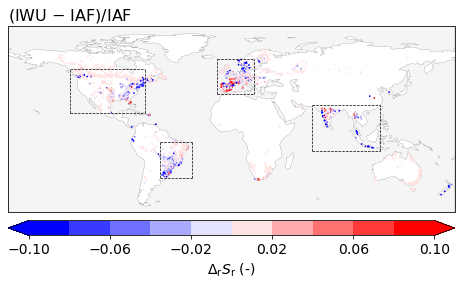

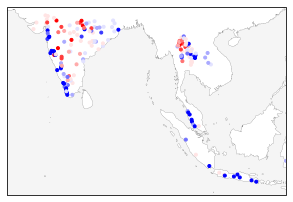

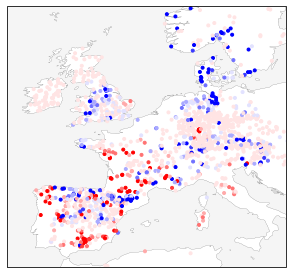

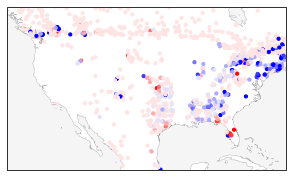

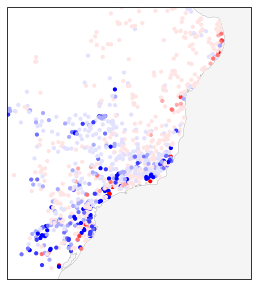

In [28]:
# RELATIVE DIFFERENCES IN SR IWU VS IA
c = pd.read_csv(f'{data_dir}/catchment_characteristics_gswp-p_gleam-ep_gswp-t.csv',index_col=0)

er_df['lat'] = c.lat
er_df['lon'] = c.lon

er_df_a = er_df[(er_df.lat<lat_max_a)&(er_df.lat>lat_min_a)&(er_df.lon<lon_max_a)&(er_df.lon>lon_min_a)]
er_df_e = er_df[(er_df.lat<lat_max_e)&(er_df.lat>lat_min_e)&(er_df.lon<lon_max_e)&(er_df.lon>lon_min_e)]
er_df_u = er_df[(er_df.lat<lat_max_u)&(er_df.lat>lat_min_u)&(er_df.lon<lon_max_u)&(er_df.lon>lon_min_u)]
er_df_s = er_df[(er_df.lat<lat_max_s)&(er_df.lat>lat_min_s)&(er_df.lon<lon_max_s)&(er_df.lon>lon_min_s)]

bounds = np.linspace(-0.1,0.1,11)
bounds2 = np.linspace(-0.1,0.1,6)
cmap = cm.get_cmap('bwr')
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# no irrigation vs fiwu
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.001)
ax.add_feature(cartopy.feature.OCEAN, zorder=1,facecolor='whitesmoke', edgecolor='k',linewidth=0.12)
ax.set_global()

ax.plot([lon_min_a,lon_max_a],[lat_max_a,lat_max_a],'k--',zorder=2,linewidth=0.7)
ax.plot([lon_min_a,lon_max_a],[lat_min_a,lat_min_a],'k--',zorder=2,linewidth=0.7)
ax.plot([lon_min_a,lon_min_a],[lat_min_a,lat_max_a],'k--',zorder=2,linewidth=0.7)
ax.plot([lon_max_a,lon_max_a],[lat_min_a,lat_max_a],'k--',zorder=2,linewidth=0.7)

ax.plot([lon_min_e,lon_max_e],[lat_max_e,lat_max_e],'k--',linewidth=0.7)
ax.plot([lon_min_e,lon_max_e],[lat_min_e,lat_min_e],'k--',linewidth=0.7)
ax.plot([lon_min_e,lon_min_e],[lat_min_e,lat_max_e],'k--',linewidth=0.7)
ax.plot([lon_max_e,lon_max_e],[lat_min_e,lat_max_e],'k--',linewidth=0.7)

ax.plot([lon_min_u,lon_max_u],[lat_max_u,lat_max_u],'k--',linewidth=0.7)
ax.plot([lon_min_u,lon_max_u],[lat_min_u,lat_min_u],'k--',linewidth=0.7)
ax.plot([lon_min_u,lon_min_u],[lat_min_u,lat_max_u],'k--',linewidth=0.7)
ax.plot([lon_max_u,lon_max_u],[lat_min_u,lat_max_u],'k--',linewidth=0.7)

ax.plot([lon_min_s,lon_max_s],[lat_max_s,lat_max_s],'k--',linewidth=0.7)
ax.plot([lon_min_s,lon_max_s],[lat_min_s,lat_min_s],'k--',linewidth=0.7)
ax.plot([lon_min_s,lon_min_s],[lat_min_s,lat_max_s],'k--',linewidth=0.7)
ax.plot([lon_max_s,lon_max_s],[lat_min_s,lat_max_s],'k--',linewidth=0.7)

ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(sr_df.lon,sr_df.lat,c=er_df['fopt_fiwu']*-1,s=0.5,cmap=cmap,norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='both', pad=0.02,norm=norm,ticks=bounds2,aspect=30)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(label='$\Delta_\mathrm{r} S_\mathrm{r}$ (-)', size=14)
ax.set_title('(IWU $-$ IAF)/IAF',loc='left',size=16)
fig.savefig(f'{fig_dir}/srreldiff_map_iaf_fiwu.jpg',bbox_inches='tight',dpi=300)

# asia
fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.001)
ax.add_feature(cartopy.feature.OCEAN, zorder=1,facecolor='whitesmoke', edgecolor='k',linewidth=0.12)
ax.set_global()
ax.set_xlim(lon_min_a,lon_max_a)
ax.set_ylim(lat_min_a,lat_max_a)
s = ax.scatter(er_df.lon,er_df.lat,c=er_df['fopt_fiwu']*-1,s=9,cmap=cmap,norm=norm)
fig.savefig(f'{fig_dir}/srreldiff_map_T2_iaf_fiwu_asia.jpg',bbox_inches='tight',dpi=300)

# EUROPE
fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.001)
ax.add_feature(cartopy.feature.OCEAN, zorder=1,facecolor='whitesmoke', edgecolor='k',linewidth=0.12)
ax.set_global()
ax.set_xlim(lon_min_e,lon_max_e)
ax.set_ylim(lat_min_e,lat_max_e)
s = ax.scatter(sr_df.lon,sr_df.lat,c=er_df['fopt_fiwu']*-1,s=9,cmap=cmap,norm=norm)
fig.savefig(f'{fig_dir}/srreldiff_map_T2_iaf_fiwu_europe.jpg',bbox_inches='tight',dpi=300)

# USA
fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.001)
ax.add_feature(cartopy.feature.OCEAN, zorder=1,facecolor='whitesmoke', edgecolor='k',linewidth=0.12)
ax.set_global()
ax.set_xlim(lon_min_u,lon_max_u)
ax.set_ylim(lat_min_u,lat_max_u)
s = ax.scatter(sr_df.lon,sr_df.lat,c=er_df['fopt_fiwu']*-1,s=10,cmap=cmap,norm=norm)
fig.savefig(f'{fig_dir}/srreldiff_map_T2_iaf_fiwu_us.jpg',bbox_inches='tight',dpi=300)

# SOUTH AMERICA
fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.001)
ax.add_feature(cartopy.feature.OCEAN, zorder=1,facecolor='whitesmoke', edgecolor='k',linewidth=0.12)
ax.set_global()
ax.set_xlim(lon_min_s,lon_max_s)
ax.set_ylim(lat_min_s,lat_max_s)
s = ax.scatter(sr_df.lon,sr_df.lat,c=er_df['fopt_fiwu']*-1,s=10,cmap=cmap,norm=norm)
fig.savefig(f'{fig_dir}/srreldiff_map_T2_iaf_fiwu_sa.jpg',bbox_inches='tight',dpi=300)


## IA STRATIFICATION

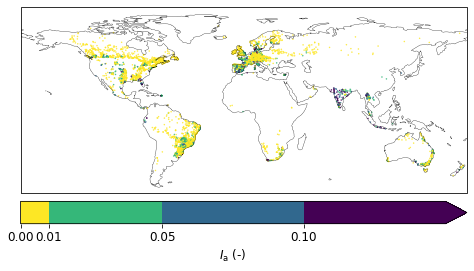

In [29]:
# combine Sr output in dataframe
sr_df_ni = pd.read_csv(f'{data_dir}/sr/sr_no_irri_combined_points_rzyear.csv', index_col=0)
sr_df_f09ia = pd.read_csv(f'{data_dir}/sr/sr_irri_f0.9ia_combined_points2_rzyear_v2.csv', index_col=0)
sr_df_fiwu2 = pd.read_csv(f'{data_dir}/sr/sr_irri_fiwu2_combined_points2_rzyear_v2.csv', index_col=0)

sr_df = pd.DataFrame(index=sr_df_ni.index)
sr_df['sr_2_f0'] = sr_df_ni['k3']
sr_df['sr_2_fiwu'] = sr_df_fiwu2['k3']
sr_df['sr_2_fopt'] = sr_df_f09ia['k3']

# sr_df = sr_df.astype(int) #int values
sr_df = sr_df.round(2)               
sr_df = sr_df.dropna()

# dataframes with errors
f0_iwu_e = np.round(sr_df.sr_2_fiwu-sr_df.sr_2_f0,3)
f0_opt_e = np.round(sr_df.sr_2_fopt-sr_df.sr_2_f0,3)
fopt_iwu_e = np.round(sr_df.sr_2_fiwu-sr_df.sr_2_fopt,3)

f0_iwu_er = np.round((sr_df.sr_2_fiwu-sr_df.sr_2_f0)/sr_df.sr_2_f0 ,4)
f0_opt_er = np.round((sr_df.sr_2_fopt-sr_df.sr_2_f0)/sr_df.sr_2_f0 ,4)
fopt_iwu_er = np.round((sr_df.sr_2_fiwu-sr_df.sr_2_fopt)/sr_df.sr_2_fopt ,4) 

e_df = pd.DataFrame(index=sr_df.index, columns=['f0_fiwu','f0_fopt','fopt_fiwu'])
e_df['f0_fiwu'] = f0_iwu_e
e_df['f0_fopt'] = f0_opt_e
e_df['fopt_fiwu'] = fopt_iwu_e

er_df = pd.DataFrame(index=sr_df.index, columns=['f0_fiwu','f0_fopt','fopt_fiwu'])
er_df['f0_fiwu'] = f0_iwu_er
er_df['f0_fopt'] = f0_opt_er
er_df['fopt_fiwu'] = fopt_iwu_er

# MAKE MAP OF AI
ir2 = pd.read_csv(f'{data_dir}/irrigation_data/combined_ia.csv',index_col=0) 
ir = ir2.hi

cc = pd.read_csv(f'{data_dir}/catchment_characteristics_gswp-p_gleam-ep_gswp-t.csv',index_col=0)
cc = cc.loc[e_df.index]

ir2['lat'] = cc.lat
ir2['lon'] = cc.lon

ir2 = ir2.loc[e_df.index]
ir = ir2.hi
iwu = cc.iwu

cmap_vd2 = plt.cm.viridis_r  # define the colormap
bounds = [0,0.0100001,0.0500001,0.100001,0.15]
bounds2 =[0,0.01,0.05,0.1]
norm = mpl.colors.BoundaryNorm(bounds, cmap_vd2.N)

# no irrigation
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(cc.lon,cc.lat,c=(ir),s=0.2,cmap=cmap_vd2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal',spacing='proportional',extend='max', pad=0.02, norm=norm,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='$I_\mathrm{a}$ (-)', size=12)
fig.savefig(f'{fig_dir}/ia_map.jpg',bbox_inches='tight',dpi=300)

In [30]:
e_df = e_df.dropna()
er_df = er_df.dropna()
e_df=e_df.iloc[:,0:2]
er_df=er_df.iloc[:,0:2]

#abs - IA bins
e_df0 = e_df[(ir<=0.01)]
e_df1 = e_df[(ir>0.01)&(ir<=0.05)]
e_df5 = e_df[(ir>0.05)&(ir<=0.1)]
e_df10 = e_df[(ir>0.1)]

#rel - IA bins
er_df0 = er_df[(ir<=0.01)]
er_df1 = er_df[(ir>0.01)&(ir<=0.05)]
er_df5 = er_df[(ir>0.05)&(ir<=0.1)]
er_df10 = er_df[(ir>0.1)]

e_df0 = e_df0*-1
e_df1 = e_df1*-1
e_df5 = e_df5*-1
e_df10 = e_df10*-1

In [31]:
ca1='br_0002356'
ca2='ca_0000689'
ca3='es_0000742'
ca4='in_0000252'

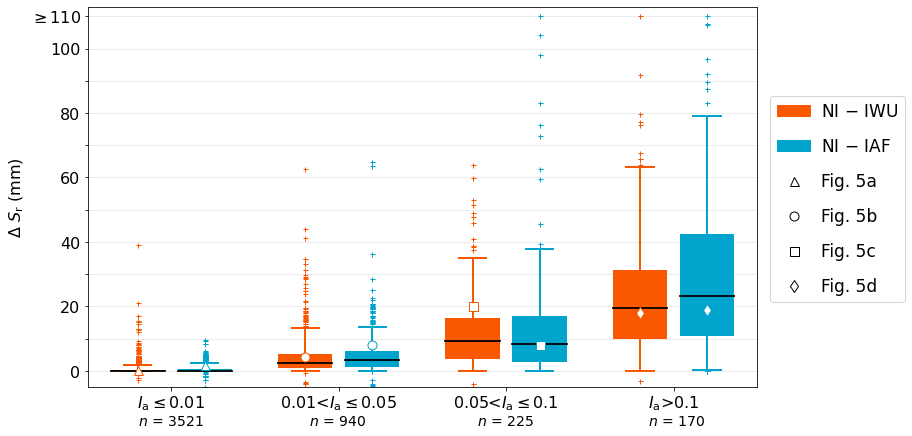

In [32]:
c2= '#00A4CCFF'
c3 = '#F95700FF'
c2f = (0, 164/255, 204/255)
c3f = (249/255, 87/255, 0)
c2e = (0, 164/255, 204/255,0)
c3e = (249/255, 87/255, 0,0)

boxprops1 = dict(facecolor=c3f,edgecolor=c3e,linewidth=2.5)
boxprops2 = dict(facecolor=c2f,edgecolor=c2e,linewidth=2.5)
medianprops1 = dict(color='k',linewidth=1.8)
medianprops2 = dict(color='k',linewidth=1.8)
meanpointprops = dict(marker='*', markeredgecolor='red',markerfacecolor='red',linestyle='None',markersize=9)
flierprops1 = dict(marker='+',markeredgecolor=c3,markersize=5)
flierprops2 = dict(marker='+',markeredgecolor=c2,markersize=5)
capprops1 = dict(linestyle='-', linewidth=2.0, color=c3)
whiskerprops1 = dict(linestyle='-', linewidth=2.0, color=c3)
capprops2 = dict(linestyle='-', linewidth=2.0, color=c2)
whiskerprops2 = dict(linestyle='-', linewidth=2.0, color=c2)

# boxplot of Sr differences - ABS
fig = plt.figure(figsize=(12,7))
p1 = ax.plot(1,-200, marker='*', markeredgecolor='red',markerfacecolor='red',linestyle='None',markersize=9)
p2 = ax.plot(1,-200,marker='^',linestyle='None', markeredgecolor='black',markerfacecolor='w',markersize=9)
p3 = ax.plot(1,-200,marker='o',linestyle='None', markeredgecolor='black',markerfacecolor='w',markersize=9)
p4 = ax.plot(1,-200,marker='s',linestyle='None', markeredgecolor='black',markerfacecolor='w',markersize=9)
p5 = ax.plot(1,-200,marker='d',linestyle='None', markeredgecolor='black',markerfacecolor='w',markersize=9)
p0 = ax.plot(1,-200,marker='^',linestyle='None', markeredgecolor='white',markerfacecolor='w',markersize=9)

ax = fig.add_subplot(111)
ax.set_axisbelow(True)
ax.grid(axis='y', color='0.9',zorder=0)
plt.subplots_adjust(wspace=0.05)
ax.boxplot(e_df0.iloc[:,0],positions=[1.1],widths=0.65,whis=[5,95],patch_artist=True,showmeans=False,boxprops=boxprops1,medianprops=medianprops1,meanprops=meanpointprops,whiskerprops=whiskerprops1,flierprops=flierprops1,capprops=capprops1,zorder=1)
ax.boxplot(e_df0.iloc[:,1],positions=[1.9],widths=0.65,whis=[5,95],patch_artist=True,showmeans=False,boxprops=boxprops2,medianprops=medianprops2,meanprops=meanpointprops,whiskerprops=whiskerprops2,flierprops=flierprops2,capprops=capprops2,zorder=1)
ax.plot([1.1],e_df0.loc[ca1].values[0],marker='^',linestyle='None', markeredgecolor=c3,markerfacecolor='w',markersize=9,zorder=2)
ax.plot([1.9],e_df0.loc[ca1].values[1],marker='^',linestyle='None', markeredgecolor=c2,markerfacecolor='w',markersize=9,zorder=2)

ax.boxplot(e_df1.iloc[:,0],positions=[3.1],widths=0.65,whis=[5,95],patch_artist=True,showmeans=False,boxprops=boxprops1,medianprops=medianprops1,meanprops=meanpointprops,whiskerprops=whiskerprops1,flierprops=flierprops1,capprops=capprops1,zorder=1)
ax.boxplot(e_df1.iloc[:,1],positions=[3.9],widths=0.65,whis=[5,95],patch_artist=True,showmeans=False,boxprops=boxprops2,medianprops=medianprops2,meanprops=meanpointprops,whiskerprops=whiskerprops2,flierprops=flierprops2,capprops=capprops2,zorder=1)
ax.plot([3.1],e_df1.loc[ca2].values[0],marker='o',linestyle='None', markeredgecolor=c3,markerfacecolor='w',markersize=9,zorder=2)
ax.plot([3.9],e_df1.loc[ca2].values[1],marker='o',linestyle='None', markeredgecolor=c2,markerfacecolor='w',markersize=9,zorder=2)

ax.boxplot(e_df5.iloc[:,0],positions=[5.1],widths=0.65,whis=[5,95],patch_artist=True,showmeans=False,boxprops=boxprops1,medianprops=medianprops1,meanprops=meanpointprops,whiskerprops=whiskerprops1,flierprops=flierprops1,capprops=capprops1,zorder=1)
ax.boxplot(e_df5.iloc[:,1],positions=[5.9],widths=0.65,whis=[5,95],patch_artist=True,showmeans=False,boxprops=boxprops2,medianprops=medianprops2,meanprops=meanpointprops,whiskerprops=whiskerprops2,flierprops=flierprops2,capprops=capprops2,zorder=1)
ax.plot([5.1],e_df5.loc[ca3].values[0],marker='s',linestyle='None', markeredgecolor=c3,markerfacecolor='w',markersize=9,zorder=2)
ax.plot([5.9],e_df5.loc[ca3].values[1],marker='s',linestyle='None', markeredgecolor=c2,markerfacecolor='w',markersize=9,zorder=2)

bp1=ax.boxplot(e_df10.iloc[:,0],positions=[7.1],widths=0.65,whis=[5,95],patch_artist=True,showmeans=False,boxprops=boxprops1,medianprops=medianprops1,meanprops=meanpointprops,whiskerprops=whiskerprops1,flierprops=flierprops1,capprops=capprops1,zorder=1)
bp2=ax.boxplot(e_df10.iloc[:,1],positions=[7.9],widths=0.65,whis=[5,95],patch_artist=True,showmeans=False,boxprops=boxprops2,medianprops=medianprops2,meanprops=meanpointprops,whiskerprops=whiskerprops2,flierprops=flierprops2,capprops=capprops2,zorder=1)
ax.plot([7.1],e_df10.loc[ca4].values[0],marker='d',linestyle='None', markeredgecolor=c3,markerfacecolor='w',markersize=9,zorder=2)
ax.plot([7.9],e_df10.loc[ca4].values[1],marker='d',linestyle='None', markeredgecolor=c2,markerfacecolor='w',markersize=9,zorder=2)

ax.set_ylim(-5,113)
ax.set_xlim(0.5,8.5)
ax.set_xticks([1.5,3.5,5.5,7.5])
ax.set_yticks([0,10,20,30,40,50,60,70,80,90,100,110])
ax.set_yticklabels(['0','','20','','40','','60','','80','','100','$\geq$110'])

ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_ylabel('$\Delta$ $S_\mathrm{r}$ (mm)',size=16)
ax.set_xticklabels(['$I_\mathrm{a}$$\leq$0.01','0.01<$I_\mathrm{a}$$\leq$0.05','0.05<$I_\mathrm{a}$$\leq$0.1','$I_\mathrm{a}$>0.1'],size=16)

ax.text(1.1,-17,'$n$ = '+str(e_df0.count()[0]),size=14)
ax.text(3.15,-17,'$n$ = '+str(e_df1.count()[0]),size=14)
ax.text(5.15,-17,'$n$ = '+str(e_df5.count()[0]),size=14)
ax.text(7.2,-17,'$n$ = '+str(e_df10.count()[0]),size=14)

# plot values <-100 at -100
ax.plot(5.9,110,color=c2,marker='+',markersize=5)
ax.plot(7.1,110,color=c3,marker='+',markersize=5)
ax.plot(7.9,110,color=c2,marker='+',markersize=5)

ax.legend([bp1["boxes"][0], bp2["boxes"][0],p2[0],p3[0],p4[0],p5[0]],
          ['NI $-$ IWU','NI $-$ IAF',
           '\n'.join(wrap(f'Fig. 5a', 10)),'\n'.join(wrap(f'Fig. 5b', 10)),'\n'.join(wrap(f'Fig. 5c', 10)),'\n'.join(wrap(f'Fig. 5d', 10))],
          ncol=1,fontsize= 17,loc='lower center',bbox_to_anchor=(1.12, 0.2),handletextpad=0.6,labelspacing=1,columnspacing = 0.5)

fig.savefig(f'{fig_dir}/box_abs_diff_ia.jpg', dpi=300, bbox_inches='tight')


In [33]:
d = pd.DataFrame(index=['$S_\mathrm{r}$-IWU $-$ $S_{\mathrm{r}}$-NI','$S_\mathrm{r}$-IA $-$ $S_\mathrm{r}$-NI'])
d['med0']=np.round(e_df0.median(),2).values
d['q250']=np.round((e_df0.quantile(0.25)),2).values
d['q750']=np.round((e_df0.quantile(0.75)),2).values


d['med1']=np.round(e_df1.median(),2).values
d['q251']=np.round((e_df1.quantile(0.25)),2).values
d['q751']=np.round((e_df1.quantile(0.75)),2).values

d['med5']=np.round(e_df5.median(),2).values
d['q255']=np.round((e_df5.quantile(0.25)),2).values
d['q755']=np.round((e_df5.quantile(0.75)),2).values

d['med10']=np.round(e_df10.median(),2).values
d['q2510']=np.round((e_df10.quantile(0.25)),2).values
d['q7510']=np.round((e_df10.quantile(0.75)),2).values

d

,med0,q250,q750,med1,q251,q751,med5,q255,q755,med10,q2510,q7510
$S_\mathrm{r}$-IWU $-$ $S_{\mathrm{r}}$-NI,-0.00,0.0,0.16,2.46,0.97,5.25,9.43,3.60,16.30,19.45,9.91,31.46
$S_\mathrm{r}$-IA $-$ $S_\mathrm{r}$-NI,0.11,0.0,0.72,3.38,1.26,6.18,8.34,2.69,17.15,23.35,10.92,42.38


In [34]:
d = pd.DataFrame(index=['$S_\mathrm{r}$-IWU $-$ $S_{\mathrm{r}}$-NI','$S_\mathrm{r}$-IA $-$ $S_\mathrm{r}$-NI'])
d['med0']=np.round(er_df0.median(),2).values
d['q250']=np.round((er_df0.quantile(0.25)),2).values
d['q750']=np.round((er_df0.quantile(0.75)),2).values


d['med1']=np.round(er_df1.median(),2).values
d['q251']=np.round((er_df1.quantile(0.25)),2).values
d['q751']=np.round((er_df1.quantile(0.75)),2).values

d['med5']=np.round(er_df5.median(),2).values
d['q255']=np.round((er_df5.quantile(0.25)),2).values
d['q755']=np.round((er_df5.quantile(0.75)),2).values

d['med10']=np.round(er_df10.median(),2).values
d['q2510']=np.round((er_df10.quantile(0.25)),2).values
d['q7510']=np.round((er_df10.quantile(0.75)),2).values
d

,med0,q250,q750,med1,q251,q751,med5,q255,q755,med10,q2510,q7510
$S_\mathrm{r}$-IWU $-$ $S_{\mathrm{r}}$-NI,0.0,-0.00,0.0,-0.02,-0.06,-0.01,-0.06,-0.14,-0.03,-0.12,-0.21,-0.07
$S_\mathrm{r}$-IA $-$ $S_\mathrm{r}$-NI,-0.0,-0.01,0.0,-0.03,-0.08,-0.01,-0.06,-0.17,-0.02,-0.15,-0.33,-0.06


## STRATIFY REGIONS

In [35]:
# combine Sr output in dataframe
sr_df_ni = pd.read_csv(f'{data_dir}/sr/sr_no_irri_combined_points_rzyear.csv', index_col=0)
sr_df_f09ia = pd.read_csv(f'{data_dir}/sr/sr_irri_f0.9ia_combined_points2_rzyear_v2.csv', index_col=0)
sr_df_fiwu2 = pd.read_csv(f'{data_dir}/sr/sr_irri_fiwu2_combined_points2_rzyear_v2.csv', index_col=0)

sr_df = pd.DataFrame(index=sr_df_ni.index)
sr_df['sr_2_f0'] = sr_df_ni['k3']
sr_df['sr_2_fiwu'] = sr_df_fiwu2['k3']
sr_df['sr_2_fopt'] = sr_df_f09ia['k3']
              
sr_df = sr_df.dropna()

# dataframes with errors
f0_iwu_e = np.round(sr_df.sr_2_fiwu-sr_df.sr_2_f0,3)
f0_opt_e = np.round(sr_df.sr_2_fopt-sr_df.sr_2_f0,3)
fopt_iwu_e = np.round(sr_df.sr_2_fiwu-sr_df.sr_2_fopt,3)

f0_iwu_er = np.round((sr_df.sr_2_fiwu-sr_df.sr_2_f0)/sr_df.sr_2_f0 ,4)
f0_opt_er = np.round((sr_df.sr_2_fopt-sr_df.sr_2_f0)/sr_df.sr_2_f0 ,4)
fopt_iwu_er = np.round((sr_df.sr_2_fiwu-sr_df.sr_2_fopt)/sr_df.sr_2_fopt ,4) 

e_df = pd.DataFrame(index=sr_df.index, columns=['f0_fiwu','f0_fopt','fopt_fiwu'])
e_df['f0_fiwu'] = f0_iwu_e
e_df['f0_fopt'] = f0_opt_e
e_df['fopt_fiwu'] = fopt_iwu_e

er_df = pd.DataFrame(index=sr_df.index, columns=['f0_fiwu','f0_fopt','fopt_fiwu'])
er_df['f0_fiwu'] = f0_iwu_er
er_df['f0_fopt'] = f0_opt_er
er_df['fopt_fiwu'] = fopt_iwu_er

e_df = e_df*-1

In [36]:
c = pd.read_csv(f'{data_dir}/catchment_characteristics_gswp-p_gleam-ep_gswp-t.csv',index_col=0)

er_df['lat'] = c.lat
er_df['lon'] = c.lon
e_df['lat'] = c.lat
e_df['lon'] = c.lon

e_df_a = e_df[(e_df.lat<lat_max_a)&(e_df.lat>lat_min_a)&(e_df.lon<lon_max_a)&(e_df.lon>lon_min_a)]
e_df_e = e_df[(e_df.lat<lat_max_e)&(e_df.lat>lat_min_e)&(e_df.lon<lon_max_e)&(e_df.lon>lon_min_e)]
e_df_u = e_df[(e_df.lat<lat_max_u)&(e_df.lat>lat_min_u)&(e_df.lon<lon_max_u)&(e_df.lon>lon_min_u)]
e_df_s = e_df[(e_df.lat<lat_max_s)&(e_df.lat>lat_min_s)&(e_df.lon<lon_max_s)&(e_df.lon>lon_min_s)]

er_df_a = er_df[(er_df.lat<lat_max_a)&(er_df.lat>lat_min_a)&(er_df.lon<lon_max_a)&(er_df.lon>lon_min_a)]
er_df_e = er_df[(er_df.lat<lat_max_e)&(er_df.lat>lat_min_e)&(er_df.lon<lon_max_e)&(er_df.lon>lon_min_e)]
er_df_u = er_df[(er_df.lat<lat_max_u)&(er_df.lat>lat_min_u)&(er_df.lon<lon_max_u)&(er_df.lon>lon_min_u)]
er_df_s = er_df[(er_df.lat<lat_max_s)&(er_df.lat>lat_min_s)&(er_df.lon<lon_max_s)&(er_df.lon>lon_min_s)]

e_df_a = e_df_a.dropna()
er_df_a = er_df_a.dropna()
e_df_a=e_df_a.iloc[:,0:2]
er_df_a=er_df_a.iloc[:,0:2]

e_df_e = e_df_e.dropna()
er_df_e = er_df_e.dropna()
e_df_e=e_df_e.iloc[:,0:2]
er_df_e=er_df_e.iloc[:,0:2]

e_df_s = e_df_s.dropna()
er_df_s = er_df_s.dropna()
e_df_s=e_df_s.iloc[:,0:2]
er_df_s=er_df_s.iloc[:,0:2]

e_df_u = e_df_u.dropna()
er_df_u = er_df_u.dropna()
e_df_u=e_df_u.iloc[:,0:2]
er_df_u=er_df_u.iloc[:,0:2]

In [37]:
#south america
e_df = e_df_s
e_df0 = e_df[(ir>0)&(ir<=0.05)]
e_df1 = e_df[(ir>0.05)] 

d = pd.DataFrame(index=['$S_\mathrm{r}$-IWU $-$ $S_{\mathrm{r}}$-NI','$S_\mathrm{r}$-IA $-$ $S_\mathrm{r}$-NI'])
d['med0']=np.round(e_df0.median(),2).values
d['q250']=np.round((e_df0.quantile(0.25)),2).values
d['q750']=np.round((e_df0.quantile(0.75)),2).values


d['med1']=np.round(e_df1.median(),2).values
d['q251']=np.round((e_df1.quantile(0.25)),2).values
d['q751']=np.round((e_df1.quantile(0.75)),2).values

d

/tmp/ipykernel_302/1984759864.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  e_df0 = e_df[(ir>0)&(ir<=0.05)]
/tmp/ipykernel_302/1984759864.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  e_df1 = e_df[(ir>0.05)]


,med0,q250,q750,med1,q251,q751
$S_\mathrm{r}$-IWU $-$ $S_{\mathrm{r}}$-NI,0.54,0.02,2.14,12.22,7.56,18.87
$S_\mathrm{r}$-IA $-$ $S_\mathrm{r}$-NI,1.30,0.35,3.47,18.07,10.02,28.17


In [38]:
#north america
e_df = e_df_u
e_df0 = e_df[(ir>0)&(ir<=0.05)]
e_df1 = e_df[(ir>0.05)] 

d = pd.DataFrame(index=['$S_\mathrm{r}$-IWU $-$ $S_{\mathrm{r}}$-NI','$S_\mathrm{r}$-IA $-$ $S_\mathrm{r}$-NI'])
d['med0']=np.round(e_df0.median(),2).values
d['q250']=np.round((e_df0.quantile(0.25)),2).values
d['q750']=np.round((e_df0.quantile(0.75)),2).values


d['med1']=np.round(e_df1.median(),2).values
d['q251']=np.round((e_df1.quantile(0.25)),2).values
d['q751']=np.round((e_df1.quantile(0.75)),2).values

d

/tmp/ipykernel_302/579121160.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  e_df0 = e_df[(ir>0)&(ir<=0.05)]
/tmp/ipykernel_302/579121160.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  e_df1 = e_df[(ir>0.05)]


,med0,q250,q750,med1,q251,q751
$S_\mathrm{r}$-IWU $-$ $S_{\mathrm{r}}$-NI,0.03,0.00,0.64,10.01,3.42,22.55
$S_\mathrm{r}$-IA $-$ $S_\mathrm{r}$-NI,0.42,0.06,1.42,11.65,2.83,23.81


In [39]:
#europe
e_df = e_df_e
e_df0 = e_df[(ir>0)&(ir<=0.05)]
e_df1 = e_df[(ir>0.05)] 

d = pd.DataFrame(index=['$S_\mathrm{r}$-IWU $-$ $S_{\mathrm{r}}$-NI','$S_\mathrm{r}$-IA $-$ $S_\mathrm{r}$-NI'])
d['med0']=np.round(e_df0.median(),2).values
d['q250']=np.round((e_df0.quantile(0.25)),2).values
d['q750']=np.round((e_df0.quantile(0.75)),2).values


d['med1']=np.round(e_df1.median(),2).values

d['q251']=np.round((e_df1.quantile(0.25)),2).values
d['q751']=np.round((e_df1.quantile(0.75)),2).values

d

/tmp/ipykernel_302/3218629908.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  e_df0 = e_df[(ir>0)&(ir<=0.05)]
/tmp/ipykernel_302/3218629908.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  e_df1 = e_df[(ir>0.05)]


,med0,q250,q750,med1,q251,q751
$S_\mathrm{r}$-IWU $-$ $S_{\mathrm{r}}$-NI,0.28,0.00,1.79,10.50,4.53,19.40
$S_\mathrm{r}$-IA $-$ $S_\mathrm{r}$-NI,0.74,0.12,2.03,8.67,3.12,16.03


In [40]:
#asia
e_df = e_df_a
e_df0 = e_df[(ir>0)&(ir<=0.05)]
e_df1 = e_df[(ir>0.05)] 

d = pd.DataFrame(index=['$S_\mathrm{r}$-IWU $-$ $S_{\mathrm{r}}$-NI','$S_\mathrm{r}$-IA $-$ $S_\mathrm{r}$-NI'])
d['med0']=np.round(e_df0.median(),2).values
d['q250']=np.round((e_df0.quantile(0.25)),2).values
d['q750']=np.round((e_df0.quantile(0.75)),2).values


d['med1']=np.round(e_df1.median(),2).values
d['q251']=np.round((e_df1.quantile(0.25)),2).values
d['q751']=np.round((e_df1.quantile(0.75)),2).values

d

/tmp/ipykernel_302/2633909547.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  e_df0 = e_df[(ir>0)&(ir<=0.05)]
/tmp/ipykernel_302/2633909547.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  e_df1 = e_df[(ir>0.05)]


,med0,q250,q750,med1,q251,q751
$S_\mathrm{r}$-IWU $-$ $S_{\mathrm{r}}$-NI,3.86,1.40,8.55,21.30,12.69,41.03
$S_\mathrm{r}$-IA $-$ $S_\mathrm{r}$-NI,6.91,2.63,13.08,26.78,11.63,56.14


In [41]:
#south america
e_df = er_df_s
e_df0 = e_df[(ir>0)&(ir<=0.05)]
e_df1 = e_df[(ir>0.05)] 

d = pd.DataFrame(index=['$S_\mathrm{r}$-IWU $-$ $S_{\mathrm{r}}$-NI','$S_\mathrm{r}$-IA $-$ $S_\mathrm{r}$-NI'])
d['med0']=np.round(e_df0.median(),2).values
# d['std0']=np.round(e_df0.std(),2).values
# d['iqr0']=np.round((e_df0.quantile(0.75)-e_df0.quantile(0.25)),2).values
d['q250']=np.round((e_df0.quantile(0.25)),2).values
d['q750']=np.round((e_df0.quantile(0.75)),2).values


d['med1']=np.round(e_df1.median(),2).values
# d['std1']=np.round(e_df1.std(),2).values
# d['iqr1']=np.round((e_df1.quantile(0.75)-e_df1.quantile(0.25)),2).values
d['q251']=np.round((e_df1.quantile(0.25)),2).values
d['q751']=np.round((e_df1.quantile(0.75)),2).values

d

/tmp/ipykernel_302/721403204.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  e_df0 = e_df[(ir>0)&(ir<=0.05)]
/tmp/ipykernel_302/721403204.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  e_df1 = e_df[(ir>0.05)]


,med0,q250,q750,med1,q251,q751
$S_\mathrm{r}$-IWU $-$ $S_{\mathrm{r}}$-NI,-0.00,-0.02,-0.0,-0.12,-0.20,-0.07
$S_\mathrm{r}$-IA $-$ $S_\mathrm{r}$-NI,-0.01,-0.04,-0.0,-0.14,-0.29,-0.08


In [42]:
#north america
e_df = er_df_u
e_df0 = e_df[(ir>0)&(ir<=0.05)]
e_df1 = e_df[(ir>0.05)] 

d = pd.DataFrame(index=['$S_\mathrm{r}$-IWU $-$ $S_{\mathrm{r}}$-NI','$S_\mathrm{r}$-IA $-$ $S_\mathrm{r}$-NI'])
d['med0']=np.round(e_df0.median(),2).values
d['q250']=np.round((e_df0.quantile(0.25)),2).values
d['q750']=np.round((e_df0.quantile(0.75)),2).values


d['med1']=np.round(e_df1.median(),2).values
d['q251']=np.round((e_df1.quantile(0.25)),2).values
d['q751']=np.round((e_df1.quantile(0.75)),2).values

d

/tmp/ipykernel_302/2492679172.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  e_df0 = e_df[(ir>0)&(ir<=0.05)]
/tmp/ipykernel_302/2492679172.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  e_df1 = e_df[(ir>0.05)]


,med0,q250,q750,med1,q251,q751
$S_\mathrm{r}$-IWU $-$ $S_{\mathrm{r}}$-NI,-0.00,-0.01,0.0,-0.09,-0.16,-0.03
$S_\mathrm{r}$-IA $-$ $S_\mathrm{r}$-NI,-0.01,-0.02,-0.0,-0.11,-0.23,-0.03


In [43]:
#europe
e_df = er_df_e
e_df0 = e_df[(ir>0)&(ir<=0.05)]
e_df1 = e_df[(ir>0.05)] 

d = pd.DataFrame(index=['$S_\mathrm{r}$-IWU $-$ $S_{\mathrm{r}}$-NI','$S_\mathrm{r}$-IA $-$ $S_\mathrm{r}$-NI'])
d['med0']=np.round(e_df0.median(),2).values
d['q250']=np.round((e_df0.quantile(0.25)),2).values
d['q750']=np.round((e_df0.quantile(0.75)),2).values


d['med1']=np.round(e_df1.median(),2).values
d['q251']=np.round((e_df1.quantile(0.25)),2).values
d['q751']=np.round((e_df1.quantile(0.75)),2).values

d

/tmp/ipykernel_302/667069497.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  e_df0 = e_df[(ir>0)&(ir<=0.05)]
/tmp/ipykernel_302/667069497.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  e_df1 = e_df[(ir>0.05)]


,med0,q250,q750,med1,q251,q751
$S_\mathrm{r}$-IWU $-$ $S_{\mathrm{r}}$-NI,-0.00,-0.02,0.0,-0.09,-0.19,-0.04
$S_\mathrm{r}$-IA $-$ $S_\mathrm{r}$-NI,-0.01,-0.04,-0.0,-0.07,-0.26,-0.02


In [44]:
#asia
e_df = er_df_a
e_df0 = e_df[(ir>0)&(ir<=0.05)]
e_df1 = e_df[(ir>0.05)] 

d = pd.DataFrame(index=['$S_\mathrm{r}$-IWU $-$ $S_{\mathrm{r}}$-NI','$S_\mathrm{r}$-IA $-$ $S_\mathrm{r}$-NI'])
d['med0']=np.round(e_df0.median(),2).values
d['q250']=np.round((e_df0.quantile(0.25)),2).values
d['q750']=np.round((e_df0.quantile(0.75)),2).values


d['med1']=np.round(e_df1.median(),2).values
d['q251']=np.round((e_df1.quantile(0.25)),2).values
d['q751']=np.round((e_df1.quantile(0.75)),2).values

d

/tmp/ipykernel_302/659190456.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  e_df0 = e_df[(ir>0)&(ir<=0.05)]
/tmp/ipykernel_302/659190456.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  e_df1 = e_df[(ir>0.05)]


,med0,q250,q750,med1,q251,q751
$S_\mathrm{r}$-IWU $-$ $S_{\mathrm{r}}$-NI,-0.02,-0.04,-0.00,-0.09,-0.16,-0.05
$S_\mathrm{r}$-IA $-$ $S_\mathrm{r}$-NI,-0.03,-0.06,-0.01,-0.10,-0.21,-0.04


## STRATIFY CLIMATE ZONES

In [45]:
cz = pd.read_csv(f'{data_dir}/all_catch_table_kg_climates.csv',index_col=0)

c = pd.read_csv(f'{data_dir}/catchment_characteristics_gswp-p_gleam-ep_gswp-t.csv',index_col=0)
cz = cz.loc[c.index]
cz = cz.loc[er_df.index]
cz['lat'] = c.lat
cz['lon'] = c.lon

ir2 = pd.read_csv(f'{data_dir}/irrigation_data/combined_ia.csv',index_col=0) 
ir = ir2.hi
cz['ir'] = ir
cz['med'] = cz['median']-1
cz

,median,kg,lat,lon,ir,med
105102A,2,Aw,-15.613333,144.483611,0.022039,1
ch_0000091,25,Dfb,47.414600,9.327100,0.002953,24
221207,14,Cfb,-37.447222,148.914167,0.000000,13
221210,14,Cfb,-37.416389,149.518611,0.003163,13
226220,14,Cfb,-37.866667,146.006111,0.003135,13
...,...,...,...,...,...,...
us_0001974,13,Cfa,33.860400,-84.652100,0.007672,12
us_0006369,13,Cfa,29.718700,-98.110400,0.003252,12
us_0002163,13,Cfa,33.064600,-85.877100,0.000824,12
us_0003410,24,Dfa,41.481200,-85.477100,0.036941,23


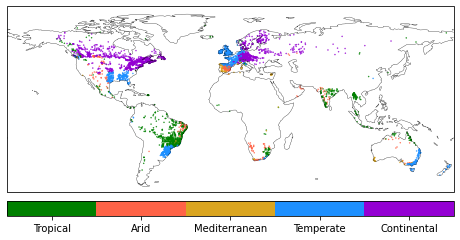

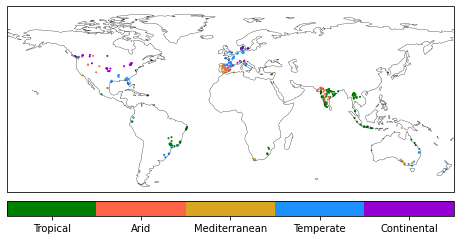

In [46]:
cz['cl'] = np.zeros(len(cz))
# tropical
ix = cz[(cz['kg']=='Af')|(cz['kg']=='Aw')|(cz['kg']=='Am')].index
cz.loc[ix,'cl'] = 1

# arid
ix = cz[(cz['kg']=='BWh')|(cz['kg']=='BWk')|(cz['kg']=='BSh')|(cz['kg']=='BSk')].index
cz.loc[ix,'cl'] = 2

# mediterranean
ix = cz[(cz['kg']=='Csa')|(cz['kg']=='Csb')|(cz['kg']=='Csc')].index
cz.loc[ix,'cl'] = 3

# temperate
ix = cz[(cz['kg']=='Cfa')|(cz['kg']=='Cfb')|(cz['kg']=='Cfc')].index
cz.loc[ix,'cl'] = 4

# continental
ix = cz[(cz['kg']=='Dfa')|(cz['kg']=='Dfb')|(cz['kg']=='Dfc')|(cz['kg']=='Dfd')].index
cz.loc[ix,'cl'] = 5

colors=['green','tomato','goldenrod','dodgerblue','darkviolet']
cm_cl = ListedColormap(colors)
bounds = np.linspace(1,6,6)
bounds2 = np.linspace(1,6,6)
norm = mpl.colors.BoundaryNorm(bounds, cm_cl.N)

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(cz.lon,cz.lat,c=cz.cl,s=0.2,cmap=cm_cl, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal',spacing='proportional',extend='neither', pad=0.02, norm=norm,ticks=bounds2,aspect=30)
cbar.set_ticks(np.arange(1.5,6.5,1))
cbar.set_ticklabels(['Tropical','Arid','Mediterranean','Temperate','Continental'],rotation=0,size=10)
fig.savefig(f'{fig_dir}/climate_zones_map_allcatch.jpg',bbox_inches='tight',dpi=300)

cz2 = cz[cz.ir>0.05]
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(cz2.lon,cz2.lat,c=cz2.cl,s=1,cmap=cm_cl, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal',spacing='proportional',extend='neither', pad=0.02, norm=norm,ticks=bounds2,aspect=30)
cbar.set_ticks(np.arange(1.5,6.5,1))
cbar.set_ticklabels(['Tropical','Arid','Mediterranean','Temperate','Continental'],rotation=0,size=10)
fig.savefig(f'{fig_dir}/climate_zones_map_ia05.jpg',bbox_inches='tight',dpi=300)


In [47]:
# combine Sr output in dataframe
sr_df_ni = pd.read_csv(f'{data_dir}/sr/sr_no_irri_combined_points_rzyear.csv', index_col=0)
sr_df_f09ia = pd.read_csv(f'{data_dir}/sr/sr_irri_f0.9ia_combined_points2_rzyear_v2.csv', index_col=0)
sr_df_fiwu2 = pd.read_csv(f'{data_dir}/sr/sr_irri_fiwu2_combined_points2_rzyear_v2.csv', index_col=0)

sr_df = pd.DataFrame(index=sr_df_ni.index)
sr_df['sr_2_f0'] = sr_df_ni['k3']
sr_df['sr_2_fiwu'] = sr_df_fiwu2['k3']
sr_df['sr_2_fopt'] = sr_df_f09ia['k3']
          
sr_df = sr_df.dropna()

# dataframes with errors
f0_iwu_e = np.round(sr_df.sr_2_fiwu-sr_df.sr_2_f0,3)
f0_opt_e = np.round(sr_df.sr_2_fopt-sr_df.sr_2_f0,3)
fopt_iwu_e = np.round(sr_df.sr_2_fiwu-sr_df.sr_2_fopt,3)

f0_iwu_er = np.round((sr_df.sr_2_fiwu-sr_df.sr_2_f0)/sr_df.sr_2_f0 ,4)
f0_opt_er = np.round((sr_df.sr_2_fopt-sr_df.sr_2_f0)/sr_df.sr_2_f0 ,4)
fopt_iwu_er = np.round((sr_df.sr_2_fiwu-sr_df.sr_2_fopt)/sr_df.sr_2_fopt ,4) 

e_df = pd.DataFrame(index=sr_df.index, columns=['f0_fiwu','f0_fopt','fopt_fiwu'])
e_df['f0_fiwu'] = f0_iwu_e
e_df['f0_fopt'] = f0_opt_e
e_df['fopt_fiwu'] = fopt_iwu_e

er_df = pd.DataFrame(index=sr_df.index, columns=['f0_fiwu','f0_fopt','fopt_fiwu'])
er_df['f0_fiwu'] = f0_iwu_er
er_df['f0_fopt'] = f0_opt_er
er_df['fopt_fiwu'] = fopt_iwu_er

e_df = e_df*-1

In [48]:
c = pd.read_csv(f'{data_dir}/catchment_characteristics_gswp-p_gleam-ep_gswp-t.csv',index_col=0)

er_df['lat'] = c.lat
er_df['lon'] = c.lon
e_df['lat'] = c.lat
e_df['lon'] = c.lon
e_df['cz'] =cz.kg
er_df['cz'] =cz.kg

a = ['Af','Am','Aw']
b1 = ['BWh','BWk']
b2 = ['BSh','BSk']
cz1 = ['Csa','Csb','Csc']
cz2 = ['Cwa','Cwb','Cwc']
cz3 = ['Cfa','Cfb','Cfc']
d1 = ['Dsa','Dsb','Dsc','Dsd']
d2 = ['Dwa','Dwb','Dwc','Dwd']
d3 = ['Dfa','Dfb','Dfc','Dfd']

e_df_tr = e_df[(e_df.cz==a[0])|(e_df.cz==a[1])|(e_df.cz==a[2])]
e_df_a = e_df[(e_df.cz==b1[0])|(e_df.cz==b1[1])|(e_df.cz==b2[0])|(e_df.cz==b2[1])]
e_df_tm = e_df[(e_df.cz==cz3[0])|(e_df.cz==cz3[1])|(e_df.cz==cz3[2])]
e_df_m = e_df[(e_df.cz==cz1[0])|(e_df.cz==cz1[1])|(e_df.cz==cz1[2])]
e_df_c = e_df[(e_df.cz==d3[0])|(e_df.cz==d3[1])|(e_df.cz==d3[2])|(e_df.cz==d3[3])]

er_df_tr = er_df[(er_df.cz==a[0])|(er_df.cz==a[1])|(er_df.cz==a[2])]
er_df_a = er_df[(er_df.cz==b1[0])|(er_df.cz==b1[1])|(er_df.cz==b2[0])|(er_df.cz==b2[1])]
er_df_tm = er_df[(er_df.cz==cz3[0])|(er_df.cz==cz3[1])|(er_df.cz==cz3[2])]
er_df_m = er_df[(er_df.cz==cz1[0])|(er_df.cz==cz1[1])|(er_df.cz==cz1[2])]
er_df_c = er_df[(er_df.cz==d3[0])|(er_df.cz==d3[1])|(er_df.cz==d3[2])|(er_df.cz==d3[3])]

e_df_a = e_df_a.dropna()
er_df_a = er_df_a.dropna()
e_df_a=e_df_a.iloc[:,0:2]
er_df_a=er_df_a.iloc[:,0:2]

e_df_tr = e_df_tr.dropna()
er_df_tr = er_df_tr.dropna()
e_df_tr=e_df_tr.iloc[:,0:2]
er_df_tr=er_df_tr.iloc[:,0:2]

e_df_tm = e_df_tm.dropna()
er_df_tm = er_df_tm.dropna()
e_df_tm=e_df_tm.iloc[:,0:2]
er_df_tm=er_df_tm.iloc[:,0:2]

e_df_m = e_df_m.dropna()
er_df_m = er_df_m.dropna()
e_df_m=e_df_m.iloc[:,0:2]
er_df_m=er_df_m.iloc[:,0:2]

e_df_c = e_df_c.dropna()
er_df_c = er_df_c.dropna()
e_df_c=e_df_c.iloc[:,0:2]
er_df_c=er_df_c.iloc[:,0:2]

In [49]:
e_df0 = e_df_tr[(ir>0.05)] 
e_df1 = e_df_a[(ir>0.05)] 
e_df2 = e_df_m[(ir>0.05)] 
e_df3 = e_df_tm[(ir>0.05)] 
e_df4 = e_df_c[(ir>0.05)] 

d = pd.DataFrame(index=['$S_\mathrm{r}$-IWU $-$ $S_{\mathrm{r}}$-NI','$S_\mathrm{r}$-IA $-$ $S_\mathrm{r}$-NI'])
d['med0']=np.round(e_df0.median(),2).values
d['q250']=np.round((e_df0.quantile(0.25)),2).values
d['q750']=np.round((e_df0.quantile(0.75)),2).values

d['med1']=np.round(e_df1.median(),2).values
d['q251']=np.round((e_df1.quantile(0.25)),2).values
d['q751']=np.round((e_df1.quantile(0.75)),2).values

d['med2']=np.round(e_df2.median(),2).values
d['q252']=np.round((e_df2.quantile(0.25)),2).values
d['q752']=np.round((e_df2.quantile(0.75)),2).values

d['med3']=np.round(e_df3.median(),2).values
d['q253']=np.round((e_df3.quantile(0.25)),2).values
d['q753']=np.round((e_df3.quantile(0.75)),2).values

d['med4']=np.round(e_df4.median(),2).values
d['q254']=np.round((e_df4.quantile(0.25)),2).values
d['q754']=np.round((e_df4.quantile(0.75)),2).values

d


/tmp/ipykernel_302/53898417.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  e_df0 = e_df_tr[(ir>0.05)]
/tmp/ipykernel_302/53898417.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  e_df1 = e_df_a[(ir>0.05)]
/tmp/ipykernel_302/53898417.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  e_df2 = e_df_m[(ir>0.05)]
/tmp/ipykernel_302/53898417.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  e_df3 = e_df_tm[(ir>0.05)]
/tmp/ipykernel_302/53898417.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  e_df4 = e_df_c[(ir>0.05)]


,med0,q250,q750,med1,q251,q751,med2,q252,q752,med3,q253,q753,med4,q254,q754
$S_\mathrm{r}$-IWU $-$ $S_{\mathrm{r}}$-NI,19.24,11.40,36.04,10.03,3.42,20.60,8.32,0.00,17.63,13.54,6.46,23.05,6.54,3.29,10.04
$S_\mathrm{r}$-IA $-$ $S_\mathrm{r}$-NI,23.72,13.14,50.20,3.80,1.94,12.66,4.96,1.18,12.89,14.94,7.52,25.25,10.18,2.81,22.46


In [50]:
e_df0 = er_df_tr[(ir>0.05)] 
e_df1 = er_df_a[(ir>0.05)] 
e_df2 = er_df_m[(ir>0.05)] 
e_df3 = er_df_tm[(ir>0.05)] 
e_df4 = er_df_c[(ir>0.05)] 

d = pd.DataFrame(index=['$S_\mathrm{r}$-IWU $-$ $S_{\mathrm{r}}$-NI','$S_\mathrm{r}$-IA $-$ $S_\mathrm{r}$-NI'])
d['med0']=np.round(e_df0.median(),2).values
d['q250']=np.round((e_df0.quantile(0.25)),2).values
d['q750']=np.round((e_df0.quantile(0.75)),2).values

d['med1']=np.round(e_df1.median(),2).values
d['q251']=np.round((e_df1.quantile(0.25)),2).values
d['q751']=np.round((e_df1.quantile(0.75)),2).values

d['med2']=np.round(e_df2.median(),2).values
d['q252']=np.round((e_df2.quantile(0.25)),2).values
d['q752']=np.round((e_df2.quantile(0.75)),2).values

d['med3']=np.round(e_df3.median(),2).values
d['q253']=np.round((e_df3.quantile(0.25)),2).values
d['q753']=np.round((e_df3.quantile(0.75)),2).values

d['med4']=np.round(e_df4.median(),2).values
d['q254']=np.round((e_df4.quantile(0.25)),2).values
d['q754']=np.round((e_df4.quantile(0.75)),2).values

d

/tmp/ipykernel_302/615444910.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  e_df0 = er_df_tr[(ir>0.05)]
/tmp/ipykernel_302/615444910.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  e_df1 = er_df_a[(ir>0.05)]
/tmp/ipykernel_302/615444910.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  e_df2 = er_df_m[(ir>0.05)]
/tmp/ipykernel_302/615444910.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  e_df3 = er_df_tm[(ir>0.05)]
/tmp/ipykernel_302/615444910.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  e_df4 = er_df_c[(ir>0.05)]


,med0,q250,q750,med1,q251,q751,med2,q252,q752,med3,q253,q753,med4,q254,q754
$S_\mathrm{r}$-IWU $-$ $S_{\mathrm{r}}$-NI,-0.09,-0.17,-0.05,-0.05,-0.11,-0.02,-0.05,-0.10,0.00,-0.14,-0.23,-0.07,-0.08,-0.15,-0.04
$S_\mathrm{r}$-IA $-$ $S_\mathrm{r}$-NI,-0.10,-0.26,-0.05,-0.03,-0.07,-0.01,-0.03,-0.08,-0.01,-0.15,-0.33,-0.07,-0.22,-0.34,-0.04


## COMBINED FIGURE REGIONS AND CLIMATES

In [51]:
# combine Sr output in dataframe
sr_df_ni = pd.read_csv(f'{data_dir}/sr/sr_no_irri_combined_points_rzyear.csv', index_col=0)
sr_df_f09ia = pd.read_csv(f'{data_dir}/sr/sr_irri_f0.9ia_combined_points2_rzyear_v2.csv', index_col=0)
sr_df_fiwu2 = pd.read_csv(f'{data_dir}/sr/sr_irri_fiwu2_combined_points2_rzyear_v2.csv', index_col=0)

sr_df = pd.DataFrame(index=sr_df_ni.index)
sr_df['sr_2_f0'] = sr_df_ni['k3']
sr_df['sr_2_fiwu'] = sr_df_fiwu2['k3']
sr_df['sr_2_fopt'] = sr_df_f09ia['k3']
               
sr_df = sr_df.dropna()

# dataframes with errors
f0_iwu_e = np.round(sr_df.sr_2_fiwu-sr_df.sr_2_f0,3)
f0_opt_e = np.round(sr_df.sr_2_fopt-sr_df.sr_2_f0,3)
fopt_iwu_e = np.round(sr_df.sr_2_fiwu-sr_df.sr_2_fopt,3)

f0_iwu_er = np.round((sr_df.sr_2_fiwu-sr_df.sr_2_f0)/sr_df.sr_2_f0 ,4)
f0_opt_er = np.round((sr_df.sr_2_fopt-sr_df.sr_2_f0)/sr_df.sr_2_f0 ,4)
fopt_iwu_er = np.round((sr_df.sr_2_fiwu-sr_df.sr_2_fopt)/sr_df.sr_2_fopt ,4) 

e_df = pd.DataFrame(index=sr_df.index, columns=['f0_fiwu','f0_fopt','fopt_fiwu'])
e_df['f0_fiwu'] = f0_iwu_e
e_df['f0_fopt'] = f0_opt_e
e_df['fopt_fiwu'] = fopt_iwu_e

er_df = pd.DataFrame(index=sr_df.index, columns=['f0_fiwu','f0_fopt','fopt_fiwu'])
er_df['f0_fiwu'] = f0_iwu_er
er_df['f0_fopt'] = f0_opt_er
er_df['fopt_fiwu'] = fopt_iwu_er

ir2 = pd.read_csv(f'{data_dir}/irrigation_data/combined_ia.csv',index_col=0) 
ir = ir2.hi

e_df = e_df*-1

c = pd.read_csv(f'{data_dir}/catchment_characteristics_gswp-p_gleam-ep_gswp-t.csv',index_col=0)

er_df['lat'] = c.lat
er_df['lon'] = c.lon
e_df['lat'] = c.lat
e_df['lon'] = c.lon

e_df_a = e_df[(e_df.lat<lat_max_a)&(e_df.lat>lat_min_a)&(e_df.lon<lon_max_a)&(e_df.lon>lon_min_a)]
e_df_e = e_df[(e_df.lat<lat_max_e)&(e_df.lat>lat_min_e)&(e_df.lon<lon_max_e)&(e_df.lon>lon_min_e)]
e_df_u = e_df[(e_df.lat<lat_max_u)&(e_df.lat>lat_min_u)&(e_df.lon<lon_max_u)&(e_df.lon>lon_min_u)]
e_df_s = e_df[(e_df.lat<lat_max_s)&(e_df.lat>lat_min_s)&(e_df.lon<lon_max_s)&(e_df.lon>lon_min_s)]

er_df_a = er_df[(er_df.lat<lat_max_a)&(er_df.lat>lat_min_a)&(er_df.lon<lon_max_a)&(er_df.lon>lon_min_a)]
er_df_e = er_df[(er_df.lat<lat_max_e)&(er_df.lat>lat_min_e)&(er_df.lon<lon_max_e)&(er_df.lon>lon_min_e)]
er_df_u = er_df[(er_df.lat<lat_max_u)&(er_df.lat>lat_min_u)&(er_df.lon<lon_max_u)&(er_df.lon>lon_min_u)]
er_df_s = er_df[(er_df.lat<lat_max_s)&(er_df.lat>lat_min_s)&(er_df.lon<lon_max_s)&(er_df.lon>lon_min_s)]

e_df_as = e_df_a.dropna()
er_df_as = er_df_a.dropna()
e_df_as=e_df_as.iloc[:,0:2]
er_df_as=er_df_as.iloc[:,0:2]

e_df_e = e_df_e.dropna()
er_df_e = er_df_e.dropna()
e_df_e=e_df_e.iloc[:,0:2]
er_df_e=er_df_e.iloc[:,0:2]

e_df_s = e_df_s.dropna()
er_df_s = er_df_s.dropna()
e_df_s=e_df_s.iloc[:,0:2]
er_df_s=er_df_s.iloc[:,0:2]

e_df_u = e_df_u.dropna()
er_df_u = er_df_u.dropna()
e_df_u=e_df_u.iloc[:,0:2]
er_df_u=er_df_u.iloc[:,0:2]

In [52]:
# combine Sr output in dataframe
sr_df_ni = pd.read_csv(f'{data_dir}/sr/sr_no_irri_combined_points_rzyear.csv', index_col=0)
sr_df_f09ia = pd.read_csv(f'{data_dir}/sr/sr_irri_f0.9ia_combined_points2_rzyear_v2.csv', index_col=0)
sr_df_fiwu2 = pd.read_csv(f'{data_dir}/sr/sr_irri_fiwu2_combined_points2_rzyear_v2.csv', index_col=0)

sr_df = pd.DataFrame(index=sr_df_ni.index)
sr_df['sr_2_f0'] = sr_df_ni['k3']
sr_df['sr_2_fiwu'] = sr_df_fiwu2['k3']
sr_df['sr_2_fopt'] = sr_df_f09ia['k3']
              
sr_df = sr_df.dropna()

# dataframes with errors
f0_iwu_e = np.round(sr_df.sr_2_fiwu-sr_df.sr_2_f0,3)
f0_opt_e = np.round(sr_df.sr_2_fopt-sr_df.sr_2_f0,3)
fopt_iwu_e = np.round(sr_df.sr_2_fiwu-sr_df.sr_2_fopt,3)

f0_iwu_er = np.round((sr_df.sr_2_fiwu-sr_df.sr_2_f0)/sr_df.sr_2_f0 ,4)
f0_opt_er = np.round((sr_df.sr_2_fopt-sr_df.sr_2_f0)/sr_df.sr_2_f0 ,4)
fopt_iwu_er = np.round((sr_df.sr_2_fiwu-sr_df.sr_2_fopt)/sr_df.sr_2_fopt ,4) 

e_df = pd.DataFrame(index=sr_df.index, columns=['f0_fiwu','f0_fopt','fopt_fiwu'])
e_df['f0_fiwu'] = f0_iwu_e
e_df['f0_fopt'] = f0_opt_e
e_df['fopt_fiwu'] = fopt_iwu_e

er_df = pd.DataFrame(index=sr_df.index, columns=['f0_fiwu','f0_fopt','fopt_fiwu'])
er_df['f0_fiwu'] = f0_iwu_er
er_df['f0_fopt'] = f0_opt_er
er_df['fopt_fiwu'] = fopt_iwu_er

ir2 = pd.read_csv(f'{data_dir}/irrigation_data/combined_ia.csv',index_col=0) 
ir = ir2.hi

e_df = e_df*-1

c = pd.read_csv(f'{data_dir}/catchment_characteristics_gswp-p_gleam-ep_gswp-t.csv',index_col=0)
cz = pd.read_csv(f'{data_dir}/all_catch_table_kg_climates.csv',index_col=0)

er_df['lat'] = c.lat
er_df['lon'] = c.lon
e_df['lat'] = c.lat
e_df['lon'] = c.lon
e_df['cz'] =cz.kg
er_df['cz'] =cz.kg

a = ['Af','Am','Aw']
b1 = ['BWh','BWk']
b2 = ['BSh','BSk']
cz1 = ['Csa','Csb','Csc']
cz2 = ['Cwa','Cwb','Cwc']
cz3 = ['Cfa','Cfb','Cfc']
d1 = ['Dsa','Dsb','Dsc','Dsd']
d2 = ['Dwa','Dwb','Dwc','Dwd']
d3 = ['Dfa','Dfb','Dfc','Dfd']

e_df_tr = e_df[(e_df.cz==a[0])|(e_df.cz==a[1])|(e_df.cz==a[2])]
e_df_a = e_df[(e_df.cz==b1[0])|(e_df.cz==b1[1])|(e_df.cz==b2[0])|(e_df.cz==b2[1])]
e_df_tm = e_df[(e_df.cz==cz3[0])|(e_df.cz==cz3[1])|(e_df.cz==cz3[2])]
e_df_m = e_df[(e_df.cz==cz1[0])|(e_df.cz==cz1[1])|(e_df.cz==cz1[2])]
e_df_c = e_df[(e_df.cz==d3[0])|(e_df.cz==d3[1])|(e_df.cz==d3[2])|(e_df.cz==d3[3])]

er_df_tr = er_df[(er_df.cz==a[0])|(er_df.cz==a[1])|(er_df.cz==a[2])]
er_df_a = er_df[(er_df.cz==b1[0])|(er_df.cz==b1[1])|(er_df.cz==b2[0])|(er_df.cz==b2[1])]
er_df_tm = er_df[(er_df.cz==cz3[0])|(er_df.cz==cz3[1])|(er_df.cz==cz3[2])]
er_df_m = er_df[(er_df.cz==cz1[0])|(er_df.cz==cz1[1])|(er_df.cz==cz1[2])]
er_df_c = er_df[(er_df.cz==d3[0])|(er_df.cz==d3[1])|(er_df.cz==d3[2])|(er_df.cz==d3[3])]

e_df_a = e_df_a.dropna()
er_df_a = er_df_a.dropna()
e_df_a=e_df_a.iloc[:,0:2]
er_df_a=er_df_a.iloc[:,0:2]

e_df_tr = e_df_tr.dropna()
er_df_tr = er_df_tr.dropna()
e_df_tr=e_df_tr.iloc[:,0:2]
er_df_tr=er_df_tr.iloc[:,0:2]

e_df_tm = e_df_tm.dropna()
er_df_tm = er_df_tm.dropna()
e_df_tm=e_df_tm.iloc[:,0:2]
er_df_tm=er_df_tm.iloc[:,0:2]

e_df_m = e_df_m.dropna()
er_df_m = er_df_m.dropna()
e_df_m=e_df_m.iloc[:,0:2]
er_df_m=er_df_m.iloc[:,0:2]

e_df_c = e_df_c.dropna()
er_df_c = er_df_c.dropna()
e_df_c=e_df_c.iloc[:,0:2]
er_df_c=er_df_c.iloc[:,0:2]

/tmp/ipykernel_302/1462815159.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  e_df0 = e_df[(ir>0)&(ir<=0.05)]
/tmp/ipykernel_302/1462815159.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  e_df1 = e_df[(ir>0.05)]
/tmp/ipykernel_302/1462815159.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  e_df2 = e_df[(ir>0.05)&(ir<=0.1)]
/tmp/ipykernel_302/1462815159.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  e_df3 = e_df[(ir>0.1)]
/tmp/ipykernel_302/1462815159.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  e_df0 = e_df[(ir>0)&(ir<=0.05)]
/tmp/ipykernel_302/1462815159.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  e_df1 = e_df[(ir>0.05)]
/tmp/ipykernel_302/1462815159.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  e_df2 = e_df[(ir>0.05)&(ir

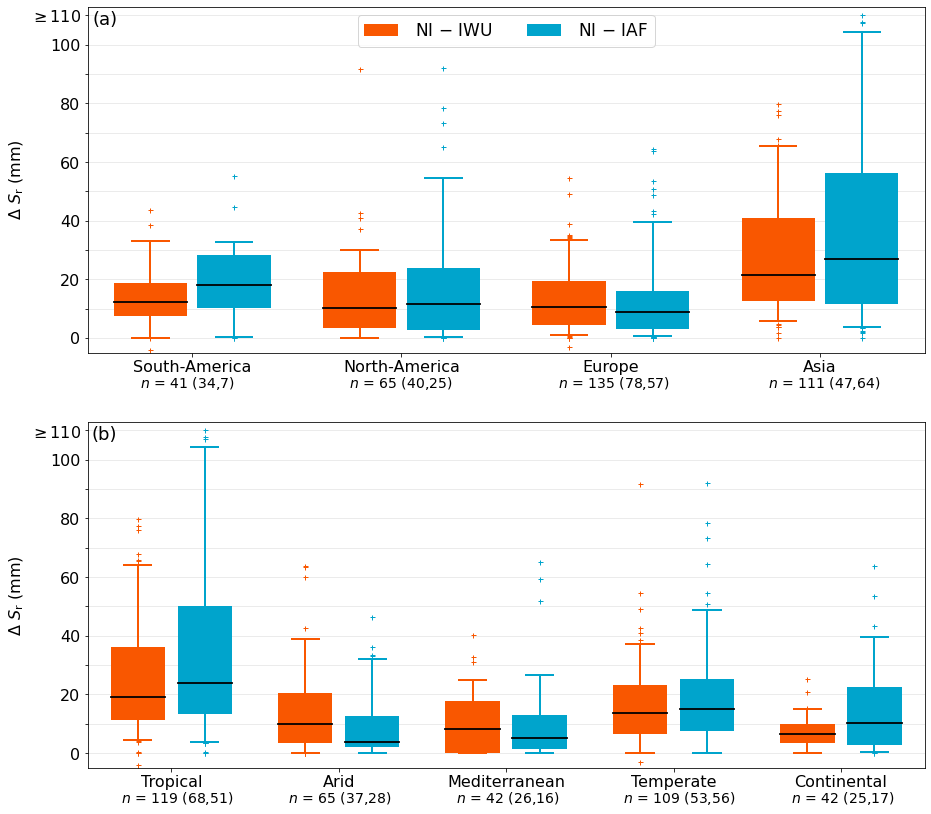

In [53]:
c2= '#00A4CCFF'
c3 = '#F95700FF'
c2f = (0, 164/255, 204/255)
c3f = (249/255, 87/255, 0)
c2e = (0, 164/255, 204/255,0)
c3e = (249/255, 87/255, 0,0)

boxprops1 = dict(facecolor=c3f,edgecolor=c3e,linewidth=2.5)
boxprops2 = dict(facecolor=c2f,edgecolor=c2e,linewidth=2.5)
medianprops1 = dict(color='k',linewidth=1.8)
medianprops2 = dict(color='k',linewidth=1.8)
meanpointprops = dict(marker='*', markeredgecolor='red',markerfacecolor='red',linestyle='None',markersize=9)
flierprops1 = dict(marker='+',markeredgecolor=c3,markersize=5)
flierprops2 = dict(marker='+',markeredgecolor=c2,markersize=5)
capprops1 = dict(linestyle='-', linewidth=2.0, color=c3)
whiskerprops1 = dict(linestyle='-', linewidth=2.0, color=c3)
capprops2 = dict(linestyle='-', linewidth=2.0, color=c2)
whiskerprops2 = dict(linestyle='-', linewidth=2.0, color=c2)

ir2 = pd.read_csv(f'{data_dir}/irrigation_data/combined_ia.csv',index_col=0) 
ir = ir2.hi

# boxplot of Sr differences - ABS
fig = plt.figure(figsize=(15,14))

# south america
e_df = e_df_s
e_df0 = e_df[(ir>0)&(ir<=0.05)]
e_df1 = e_df[(ir>0.05)]
e_df2 = e_df[(ir>0.05)&(ir<=0.1)]
e_df3 = e_df[(ir>0.1)]
ax = fig.add_subplot(211)
ax.set_axisbelow(True)
ax.grid(axis='y', color='0.9',zorder=0)
bpp1=ax.boxplot(e_df1.iloc[:,0],positions=[1.1],widths=0.7,whis=[5,95],patch_artist=True,showmeans=False,boxprops=boxprops1,medianprops=medianprops1,meanprops=meanpointprops,whiskerprops=whiskerprops1,flierprops=flierprops1,capprops=capprops1,zorder=1)
bpp2=ax.boxplot(e_df1.iloc[:,1],positions=[1.9],widths=0.7,whis=[5,95],patch_artist=True,showmeans=False,boxprops=boxprops2,medianprops=medianprops2,meanprops=meanpointprops,whiskerprops=whiskerprops2,flierprops=flierprops2,capprops=capprops2,zorder=1)
ax.text(1,-17,'$n$ = '+str(e_df1.count()[0])+' ('+str(e_df2.count()[0])+','+str(e_df3.count()[0])+')',size=14)

# north america
e_df = e_df_u
e_df0 = e_df[(ir>0)&(ir<=0.05)]
e_df1 = e_df[(ir>0.05)] 
e_df2 = e_df[(ir>0.05)&(ir<=0.1)]
e_df3 = e_df[(ir>0.1)]
bp1=ax.boxplot(e_df1.iloc[:,0],positions=[3.1],widths=0.7,whis=[5,95],patch_artist=True,showmeans=False,boxprops=boxprops1,medianprops=medianprops1,meanprops=meanpointprops,whiskerprops=whiskerprops1,flierprops=flierprops1,capprops=capprops1,zorder=1)
bp2=ax.boxplot(e_df1.iloc[:,1],positions=[3.9],widths=0.7,whis=[5,95],patch_artist=True,showmeans=False,boxprops=boxprops2,medianprops=medianprops2,meanprops=meanpointprops,whiskerprops=whiskerprops2,flierprops=flierprops2,capprops=capprops2,zorder=1)
ax.text(3,-17,'$n$ = '+str(e_df1.count()[0])+' ('+str(e_df2.count()[0])+','+str(e_df3.count()[0])+')',size=14)
p2 = ax.plot(1,-200,'r*',markersize=9)

# europe
e_df = e_df_e
e_df0 = e_df[(ir>0)&(ir<=0.05)]
e_df1 = e_df[(ir>0.05)]
e_df2 = e_df[(ir>0.05)&(ir<=0.1)]
e_df3 = e_df[(ir>0.1)]
bp1=ax.boxplot(e_df1.iloc[:,0],positions=[5.1],widths=0.7,whis=[5,95],patch_artist=True,showmeans=False,boxprops=boxprops1,medianprops=medianprops1,meanprops=meanpointprops,whiskerprops=whiskerprops1,flierprops=flierprops1,capprops=capprops1,zorder=1)
bp2=ax.boxplot(e_df1.iloc[:,1],positions=[5.9],widths=0.7,whis=[5,95],patch_artist=True,showmeans=False,boxprops=boxprops2,medianprops=medianprops2,meanprops=meanpointprops,whiskerprops=whiskerprops2,flierprops=flierprops2,capprops=capprops2,zorder=1)
ax.text(5,-17,'$n$ = '+str(e_df1.count()[0])+' ('+str(e_df2.count()[0])+','+str(e_df3.count()[0])+')',size=14)
p2 = ax.plot(1,-200,'r*',markersize=9)

# asia
e_df = e_df_as
e_df0 = e_df[(ir>0)&(ir<=0.05)]
e_df1 = e_df[(ir>0.05)] 
e_df2 = e_df[(ir>0.05)&(ir<=0.1)]
e_df3 = e_df[(ir>0.1)]
bp1=ax.boxplot(e_df1.iloc[:,0],positions=[7.1],widths=0.7,whis=[5,95],patch_artist=True,showmeans=False,boxprops=boxprops1,medianprops=medianprops1,meanprops=meanpointprops,whiskerprops=whiskerprops1,flierprops=flierprops1,capprops=capprops1,zorder=1)
bp2=ax.boxplot(e_df1.iloc[:,1],positions=[7.9],widths=0.7,whis=[5,95],patch_artist=True,showmeans=False,boxprops=boxprops2,medianprops=medianprops2,meanprops=meanpointprops,whiskerprops=whiskerprops2,flierprops=flierprops2,capprops=capprops2,zorder=1)
ax.text(7,-17,'$n$ = '+str(e_df1.count()[0])+' ('+str(e_df2.count()[0])+','+str(e_df3.count()[0])+')',size=14)
ax.set_ylim(-5,113)
ax.set_xlim(0.5,8.5)
ax.set_xticks([1.5,3.5,5.5,7.5])
ax.set_yticks([0,10,20,30,40,50,60,70,80,90,100,110])
ax.set_yticklabels(['0','','20','','40','','60','','80','','100','$\geq$110'])
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xticklabels(['South-America','North-America','Europe','Asia'],size=16)
ax.set_ylabel('$\Delta$ $S_\mathrm{r}$ (mm)',size=16)

# plot values <-110 at -110
ax.plot(7.9,110,color=c2,marker='+',markersize=5)
ax.text(0.55,107,'(a)',size=18)

ax.legend([bpp1["boxes"][0], bpp2["boxes"][0]],
          ['NI $-$ IWU','NI $-$ IAF'],
          ncol=2,fontsize= 17,loc='upper center',handletextpad=1,labelspacing=1,columnspacing = 2)

boxprops1 = dict(facecolor=c3f,edgecolor=c3e,linewidth=2.5)
boxprops2 = dict(facecolor=c2f,edgecolor=c2e,linewidth=2.5)
medianprops1 = dict(color='k',linewidth=1.8)
medianprops2 = dict(color='k',linewidth=1.8)
meanpointprops = dict(marker='*', markeredgecolor='red',markerfacecolor='red',linestyle='None',markersize=9)
flierprops1 = dict(marker='+',markeredgecolor=c3,markersize=5)
flierprops2 = dict(marker='+',markeredgecolor=c2,markersize=5)
capprops1 = dict(linestyle='-', linewidth=2.0, color=c3)
whiskerprops1 = dict(linestyle='-', linewidth=2.0, color=c3)
capprops2 = dict(linestyle='-', linewidth=2.0, color=c2)
whiskerprops2 = dict(linestyle='-', linewidth=2.0, color=c2)

ir2 = pd.read_csv(f'{data_dir}/irrigation_data/combined_ia.csv',index_col=0) 
ir = ir2.hi

# tropical
e_df = e_df_tr
e_df0 = e_df[(ir<=0.05)]
e_df1 = e_df[(ir>0.05)]
e_df2 = e_df[(ir>0.05)&(ir<=0.1)]
e_df3 = e_df[(ir>0.1)]
ax = fig.add_subplot(212)
ax.set_axisbelow(True)
ax.grid(axis='y', color='0.9',zorder=0)
bp1=ax.boxplot(e_df1.iloc[:,0],positions=[1.1],widths=0.65,whis=[5,95],patch_artist=True,showmeans=False,boxprops=boxprops1,medianprops=medianprops1,meanprops=meanpointprops,whiskerprops=whiskerprops1,flierprops=flierprops1,capprops=capprops1,zorder=1)
bp2=ax.boxplot(e_df1.iloc[:,1],positions=[1.9],widths=0.65,whis=[5,95],patch_artist=True,showmeans=False,boxprops=boxprops2,medianprops=medianprops2,meanprops=meanpointprops,whiskerprops=whiskerprops2,flierprops=flierprops2,capprops=capprops2,zorder=1)
ax.text(0.9,-17,'$n$ = '+str(e_df1.count()[0])+' ('+str(e_df2.count()[0])+','+str(e_df3.count()[0])+')',size=14)

bpp1=ax.boxplot(e_df1.iloc[:,0],positions=[-9.1],widths=0.65,whis=[5,95],patch_artist=True,showmeans=False,boxprops=boxprops1,medianprops=medianprops1,meanprops=meanpointprops,whiskerprops=whiskerprops1,flierprops=flierprops1,capprops=capprops1,zorder=1)
bpp2=ax.boxplot(e_df1.iloc[:,1],positions=[-9.9],widths=0.65,whis=[5,95],patch_artist=True,showmeans=False,boxprops=boxprops2,medianprops=medianprops2,meanprops=meanpointprops,whiskerprops=whiskerprops2,flierprops=flierprops2,capprops=capprops2,zorder=1)

# arid
e_df = e_df_a
e_df0 = e_df[(ir>0)&(ir<=0.05)]
e_df1 = e_df[(ir>0.05)] 
e_df2 = e_df[(ir>0.05)&(ir<=0.1)]
e_df3 = e_df[(ir>0.1)]
bp1=ax.boxplot(e_df1.iloc[:,0],positions=[3.1],widths=0.65,whis=[5,95],patch_artist=True,showmeans=False,boxprops=boxprops1,medianprops=medianprops1,meanprops=meanpointprops,whiskerprops=whiskerprops1,flierprops=flierprops1,capprops=capprops1,zorder=1)
bp2=ax.boxplot(e_df1.iloc[:,1],positions=[3.9],widths=0.65,whis=[5,95],patch_artist=True,showmeans=False,boxprops=boxprops2,medianprops=medianprops2,meanprops=meanpointprops,whiskerprops=whiskerprops2,flierprops=flierprops2,capprops=capprops2,zorder=1)
p2 = ax.plot(1,-200,'r*',markersize=9)
ax.text(2.9,-17,'$n$ = '+str(e_df1.count()[0])+' ('+str(e_df2.count()[0])+','+str(e_df3.count()[0])+')',size=14)

# mediterranean
e_df = e_df_m
e_df0 = e_df[(ir>0)&(ir<=0.05)]
e_df1 = e_df[(ir>0.05)]
e_df2 = e_df[(ir>0.05)&(ir<=0.1)]
e_df3 = e_df[(ir>0.1)]
bp1=ax.boxplot(e_df1.iloc[:,0],positions=[5.1],widths=0.65,whis=[5,95],patch_artist=True,showmeans=False,boxprops=boxprops1,medianprops=medianprops1,meanprops=meanpointprops,whiskerprops=whiskerprops1,flierprops=flierprops1,capprops=capprops1,zorder=1)
bp2=ax.boxplot(e_df1.iloc[:,1],positions=[5.9],widths=0.65,whis=[5,95],patch_artist=True,showmeans=False,boxprops=boxprops2,medianprops=medianprops2,meanprops=meanpointprops,whiskerprops=whiskerprops2,flierprops=flierprops2,capprops=capprops2,zorder=1)
ax.text(4.9,-17,'$n$ = '+str(e_df1.count()[0])+' ('+str(e_df2.count()[0])+','+str(e_df3.count()[0])+')',size=14)

# temperate
e_df = e_df_tm
e_df0 = e_df[(ir>0)&(ir<=0.05)]
e_df1 = e_df[(ir>0.05)]
e_df2 = e_df[(ir>0.05)&(ir<=0.1)]
e_df3 = e_df[(ir>0.1)]
bp1=ax.boxplot(e_df1.iloc[:,0],positions=[7.1],widths=0.65,whis=[5,95],patch_artist=True,showmeans=False,boxprops=boxprops1,medianprops=medianprops1,meanprops=meanpointprops,whiskerprops=whiskerprops1,flierprops=flierprops1,capprops=capprops1,zorder=1)
bp2=ax.boxplot(e_df1.iloc[:,1],positions=[7.9],widths=0.65,whis=[5,95],patch_artist=True,showmeans=False,boxprops=boxprops2,medianprops=medianprops2,meanprops=meanpointprops,whiskerprops=whiskerprops2,flierprops=flierprops2,capprops=capprops2,zorder=1)
ax.text(6.9,-17,'$n$ = '+str(e_df1.count()[0])+' ('+str(e_df2.count()[0])+','+str(e_df3.count()[0])+')',size=14)

# continental
e_df = e_df_c
e_df0 = e_df[(ir>0)&(ir<=0.05)]
e_df1 = e_df[(ir>0.05)] 
e_df2 = e_df[(ir>0.05)&(ir<=0.1)]
e_df3 = e_df[(ir>0.1)]
bp1=ax.boxplot(e_df1.iloc[:,0],positions=[9.1],widths=0.65,whis=[5,95],patch_artist=True,showmeans=False,boxprops=boxprops1,medianprops=medianprops1,meanprops=meanpointprops,whiskerprops=whiskerprops1,flierprops=flierprops1,capprops=capprops1,zorder=1)
bp2=ax.boxplot(e_df1.iloc[:,1],positions=[9.9],widths=0.65,whis=[5,95],patch_artist=True,showmeans=False,boxprops=boxprops2,medianprops=medianprops2,meanprops=meanpointprops,whiskerprops=whiskerprops2,flierprops=flierprops2,capprops=capprops2,zorder=1)
ax.text(8.9,-17,'$n$ = '+str(e_df1.count()[0])+' ('+str(e_df2.count()[0])+','+str(e_df3.count()[0])+')',size=14)
ax.set_ylim(-5,113)
ax.set_xlim(0.5,10.5)
ax.set_xticks([1.5,3.5,5.5,7.5,9.5])
ax.set_yticks([0,10,20,30,40,50,60,70,80,90,100,110])
ax.set_yticklabels(['0','','20','','40','','60','','80','','100','$\geq$110'])
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xticklabels(['Tropical','Arid','Mediterranean','Temperate','Continental'],size=16)
ax.set_ylabel('$\Delta$ $S_\mathrm{r}$ (mm)',size=16)

# plot values <-100 at -100
ax.plot(1.9,110,color=c2,marker='+',markersize=5)

p2 = ax.plot(1,-200, marker='d', markeredgecolor='black',markerfacecolor='white',linestyle = 'None',markersize=7.5)
p1 = ax.plot(1,-200,'r*',markersize=9)
ax.text(0.55,107,'(b)',size=18)

fig.savefig(f'{fig_dir}/box_abs_diff_ia_regions_climates.jpg', dpi=300, bbox_inches='tight')